--- Frame rotations

- The phase at merger or start is not constrained to hold any particular numerical
value in every simulation, and in fact it always varies in an uncontrolled way. That
would create a phase shift between `NRSur7dq4` mddes which have this phase angle
well defined, and any given nr simultion from any catalog. This amounts to a 
change in the coordinate system that are used to construct the spin-weighted
spherical harmonics ${}^{-2}Y_{lm}$. This can be quantified as ${}^{-2}Y_{lm}(\iota, \phi_1) \rightarrow {}^{-2}Y_{lm}(\iota, \phi_2)$. The question then is how can I go from the coefficients of the decomposition of 
polarizations in one set of spherical harmonics versus another?

- This would require Wigner matrix rotations of the modes. Since these are
better resolved in NR catalogs (ASSUME) we want to rotate those to the spherical 
harmonic modes from nr. This can be done using the `spherical` package quite
quickly.

- Comparing surrogate and nr modes will then require us to perform an optimization
over this general 3D rotation of the frame in which the SWSH are defined. This
would be an optimization over a quaternion.


--- Supertranslations c.f. Poincare-group transformations

- There is a Poincare rotation invariance of modes at null infinity, and GW
modes are invariant under those. The modes from nr catalogs and those from 
the `NRSur7dq4` surrogate could be related by those transformations, also
known as supertranslations. When comparing them, we might need to optimize
over supertranslations.




--- Goal 1: To be able to read and interact with all 3 catalogs at an identical footing

This implies the `nr-catalog-tools` interface to be made mature enough by using
the latest APIs provided by the `sxs` and `mayawaves` packages. 

--- Goal 2: To be able to Wigner rotate NR modes using `spherical`

This implies we are able to cast waveforms from all catalogs in the `sxs` and 
`spherical` data structures, and also that we have available all possible modes
needed for making the rotations.

--- Goal 3: Compute overlaps between each catalog and `NRSur7dq4` optimizing the
same over arbitrary Wigner rotations.

This requires an optimization over the quaternion rotor. Check if there are
optimized algorithms available to do this. Record the rotor for each simulation,
and see if that is correlated in any way with the properties of the simulation,
such as `{length, eccentricity, spin magnitudes, precessing spin, ...}`.


## Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm

import lal
import lalsimulation as ls
import mayawaves
from mayawaves.utils.catalogutils import Catalog as MWCatalog
import nrcatalogtools
import pycbc.waveform as wf

os.environ[
    "LAL_DATA_PATH"
] = "/media/prayush/Data/src/lalsuite-extra/data/lalsimulation/"

lal.MSUN_SI != Msun
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new
No version information file '.version' found


In [19]:
nrcatalogtools.__file__

'/home/prayush/miniconda3/envs/enigma_spins_v2023/lib/python3.10/site-packages/nrcatalogtools/__init__.py'

In [20]:
import sxs

In [21]:
sxs.__version__

'2024.0.26'

In [3]:
nrcatalogtools.utils.rit_catalog_info

{'cache_dir': PosixPath('/home/prayush/.cache/RIT'),
 'metadata_dir': PosixPath('/home/prayush/.cache/RIT/metadata'),
 'data_dir': PosixPath('/home/prayush/.cache/RIT/data'),
 'url': 'https://ccrgpages.rit.edu/~RITCatalog/',
 'metadata_url': 'https://ccrgpages.rit.edu/~RITCatalog//Metadata/',
 'data_url': 'https://ccrgpages.rit.edu/~RITCatalog//Data/',
 'possible_resolutions': [100, 120, 88, 118, 130, 140, 144, 160, 200],
 'metadata_file_fmts': ['RIT:BBH:{:04d}-n{:3d}-id{:d}_Metadata.txt',
  'RIT:eBBH:{:04d}-n{:3d}-ecc_Metadata.txt'],
 'waveform_file_fmts': ['ExtrapStrain_RIT-BBH-{:04d}-n{:3d}.h5',
  'ExtrapStrain_RIT-eBBH-{:04d}-n{:3d}.h5'],
 'psi4_file_fmts': ['ExtrapPsi4_RIT-BBH-{:04d}-n{:3d}-id{:d}.tar.gz',
  'ExtrapPsi4_RIT-eBBH-{:04d}-n{:3d}-ecc.tar.gz'],
 'max_id_val': 6}

## Global constants

In [4]:
total_mass = 60
inclination = 0
coa_phase = 0
distance = 1.0

sample_rate = 4096 * 4
duration = 4
delta_t = 1.0 / sample_rate
delta_f = 1.0 / duration

f_lower = 30.0

## Initiaize Catalog handlers

In [5]:
ritcatalog = nrcatalogtools.RITCatalog.load(verbosity=3)
mayacatalog = nrcatalogtools.MayaCatalog.load(verbosity=3)

mayawavescatalog = MWCatalog()

..Going to read RIT catalog metadata from cache.
Skipping download from 'https://cgpstorage.ph.utexas.edu/MAYAmetadata.pkl' because local file is newer


In [6]:
print(f"..MayaWaves catalog has {len(mayawavescatalog.simulations)} simulations")

..MayaWaves catalog has 635 simulations


In [7]:
gtsims = [f for f in mayawavescatalog.simulations if 'GT' in f]
mayasims = [f for f in mayawavescatalog.simulations if 'MAYA' in f]

In [8]:
print(f'..of these {len(gtsims)} are older GT sims, and {len(mayasims)} are newer MAYA sims')

..of these 454 are older GT sims, and 181 are newer MAYA sims


In [9]:
mayasims[0]

'MAYA0907'

In [10]:
mayawavescatalog.download_waveforms([mayasims[0]], save_wf_path='.')

Total size of requested waveforms is 0.28 GB.
----------------------------------------------------------
Catalog id: MAYA0907
name                  D8_q1.5_a1z_0.395_a2z_-0.8_M160
m1                    0.5999
m2                    0.3979
m1_irr                0.5876
m2_irr                0.3545
q                     1.5078
eta                   0.2397
a1                    0.3951
a1x                   -0.0000
a1y                   0.0000
a1z                   0.3951
a2                    0.8087
a2x                   0.0000
a2y                   -0.0000
a2z                   -0.8087
chi_eff               -0.0849
chi_p                 0.0000
f_lower_at_1MSUN      2741.2632
separation            8.0000
eccentricity          0.0098
mean_anomaly          -1.0000
merge_time            352.5249
maya file size (GB)   0.2817
lvcnr file size (GB)  0.0010


In [15]:
mayacatalog.download_waveform_data(mayasims[0], maya_format=False)

...writing to cache: /home/prayush/.cache/MAYA/data/MAYA0907.h5
...downloading https://cgpstorage.ph.utexas.edu//lvcnr_format/MAYA0907.h5


In [16]:
"https://cgpstorage.ph.utexas.edu/lvcnr_format/"

'https://cgpstorage.ph.utexas.edu/lvcnr_format/'

In [18]:
for f in mayawavescatalog.simulations:
    if not os.path.exists(os.path.join(mayacatalog.waveform_data_dir, f + ".h5")):
        print(f"\n >>> Did not find data for {f}")
        mayacatalog.download_waveform_data(f, maya_format=False)


 >>> Did not find data for MAYA0935
...writing to cache: /home/prayush/.cache/MAYA/data/MAYA0935.h5
... ... but couldnt find link: https://cgpstorage.ph.utexas.edu//lvcnr_format/MAYA0935.h5

 >>> Did not find data for MAYA0959
...writing to cache: /home/prayush/.cache/MAYA/data/MAYA0959.h5
... ... but couldnt find link: https://cgpstorage.ph.utexas.edu//lvcnr_format/MAYA0959.h5

 >>> Did not find data for MAYA0960
...writing to cache: /home/prayush/.cache/MAYA/data/MAYA0960.h5
... ... but couldnt find link: https://cgpstorage.ph.utexas.edu//lvcnr_format/MAYA0960.h5

 >>> Did not find data for MAYA0961
...writing to cache: /home/prayush/.cache/MAYA/data/MAYA0961.h5
... ... but couldnt find link: https://cgpstorage.ph.utexas.edu//lvcnr_format/MAYA0961.h5

 >>> Did not find data for MAYA0962
...writing to cache: /home/prayush/.cache/MAYA/data/MAYA0962.h5
... ... but couldnt find link: https://cgpstorage.ph.utexas.edu//lvcnr_format/MAYA0962.h5

 >>> Did not find data for MAYA0963
...writi

In [5]:
df_maya = mayacatalog.simulations_dataframe
df_maya.isna().any()[df_maya.isna().any()]

m1                      True
m2                      True
m1_irr                  True
m2_irr                  True
q                       True
eta                     True
a1x                     True
a1y                     True
a1z                     True
a2x                     True
a2y                     True
a2z                     True
eccentricity            True
mean_anomaly            True
lvcnr_file_size__GB_    True
dtype: bool

In [5]:
df_rit = ritcatalog.simulations_dataframe
df_rit.isna().any()[df_rit.isna().any()]

simulation-bibtex-keys    True
initial-ADM-energy        True
final-kick                True
dtype: bool

In [6]:
# <<< RUN ONLY ONCE >>>
# ritcatalog.download_data_for_catalog(which_data='psi4')

In [7]:
df_rit.columns

Index(['catalog-tag', 'resolution-tag', 'id-tag', 'run-name', 'data-type',
       'system-type', 'comments', 'authors-emails', 'simulation-bibtex-keys',
       'code-bibtex-keys', 'initial-data-bibtex-keys',
       'quasicircular-bibtex-keys', 'eccentricity-bibtex-keys',
       'extrapolation-bibtex-keys', 'code', 'evolution-system',
       'evolution-gauge', 'cfl', 'fd-order', 'dissipation-order',
       'eccentricity-measurement-method', 'eccentricity', 'freq-start-22',
       'freq-start-22-Hz-1Msun', 'number-of-cycles-22', 'initial-data-type',
       'initial-ADM-energy', 'initial-orbital-angular-momentum',
       'initial-ADM-angular-momentum-x', 'initial-ADM-angular-momentum-y',
       'initial-ADM-angular-momentum-z', 'initial-separation', 'initial-mass1',
       'initial-mass2', 'initial-total-mass', 'initial-bh-chi1z',
       'initial-bh-chi2z', 'relaxed-time', 'relaxed-mass1', 'relaxed-mass2',
       'relaxed-total-mass', 'relaxed-mass-ratio-1-over-2', 'relaxed-LNhatx',
     

In [8]:
df_maya.columns

Index(['simulation_name', 'GT_Tag', 'm1', 'm2', 'm1_irr', 'm2_irr', 'q', 'eta',
       'a1x', 'a1y', 'a1z', 'a2x', 'a2y', 'a2z', 'f_lower_at_1MSUN',
       'omega_orbital', 'separation', 'eccentricity', 'mean_anomaly',
       'merge_time', 'maya_file_size__GB_', 'lvcnr_file_size__GB_',
       'metadata_location', 'metadata_link', 'waveform_data_link',
       'waveform_data_location'],
      dtype='object')

/home/prayush/miniconda3/envs/enigma_spins_v2023/lib/python3.10/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/prayush/miniconda3/envs/enigma_spins_v2023/lib/python3.10/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


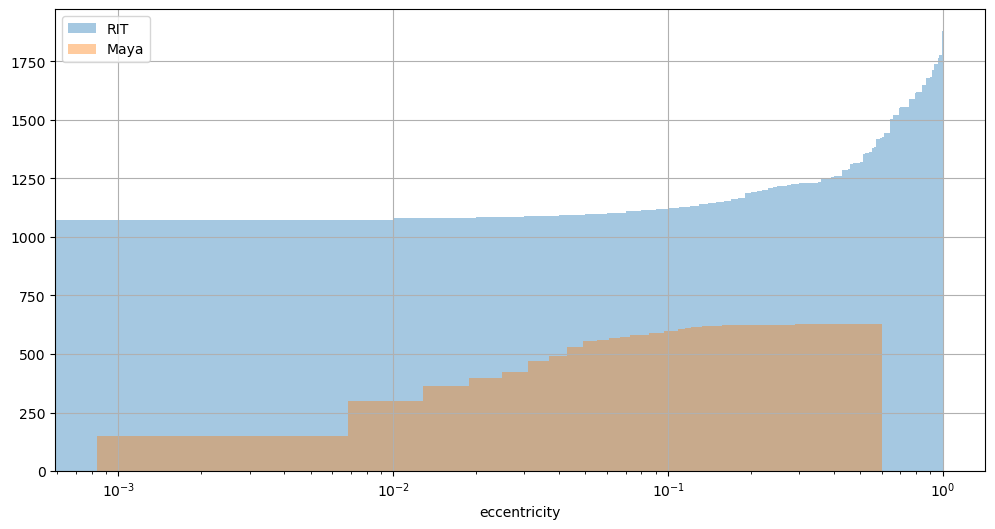

In [9]:
plt.figure(figsize=(12, 6))
plt.hist(
    np.array(df_rit["eccentricity"].to_numpy()),
    log=False,
    bins=100,
    alpha=0.4,
    cumulative=True,
    # density=True,
    label="RIT",
)
plt.hist(
    np.array(df_maya["eccentricity"].to_numpy()),
    log=False,
    bins=100,
    alpha=0.4,
    cumulative=True,
    # density=True,
    label="Maya",
)
plt.xscale("log")
plt.xlabel("eccentricity")
plt.legend()
plt.grid()
plt.show()

## Modes

### Let us examine one simulation in detail

In [6]:
nonecc_sims = df_rit[df_rit["eccentricity"] < 0.01].index.to_list()

In [7]:
one_sim = nonecc_sims[0]
print(one_sim)
one_sim_params = ritcatalog.get_parameters(one_sim, total_mass=total_mass)
one_sim_params.update({"f_lower": f_lower, "distance": distance, "delta_t": delta_t})

RIT:BBH:0001-n100-id3


[-1.69702048e-20 -1.83274592e-20 -1.96826711e-20 ...  8.12815263e-22
  8.52406442e-22  8.83202509e-22]


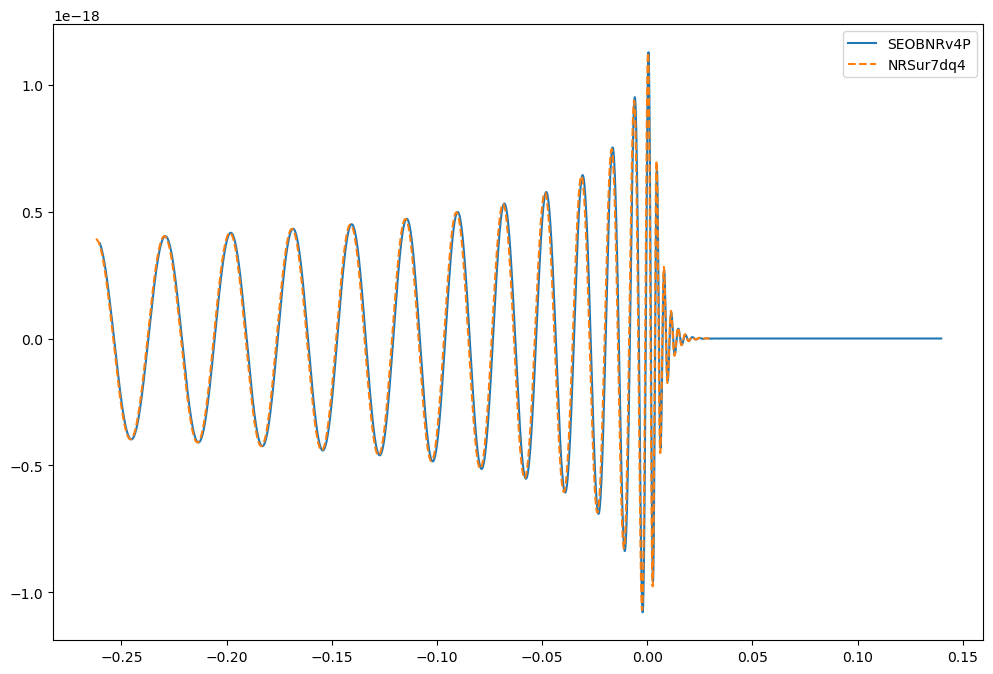

In [13]:
modes1 = wf.get_td_waveform_modes(
    approximant="SEOBNRv4P", coa_phase=coa_phase + 1.2 * np.pi / 2, **one_sim_params
)
plt.figure(figsize=(12, 8))
plt.plot(modes1[(2, 2)][0].sample_times, modes1[(2, 2)][0], label="SEOBNRv4P")

modes2 = wf.get_td_waveform_modes(
    approximant="NRSur7dq4", coa_phase=coa_phase + 0 * np.pi / 2, **one_sim_params
)

plt.plot(modes2[(2, 2)][0].sample_times, modes2[(2, 2)][0], "--", label="NRSur7dq4")
plt.legend()
print(modes1[2, 2][0].data[: len(modes2[2, 2][0].data)] - modes2[2, 2][0].data)

In [9]:
md = ritcatalog.get_metadata(one_sim)

RIT:BBH:0001-n100-id3


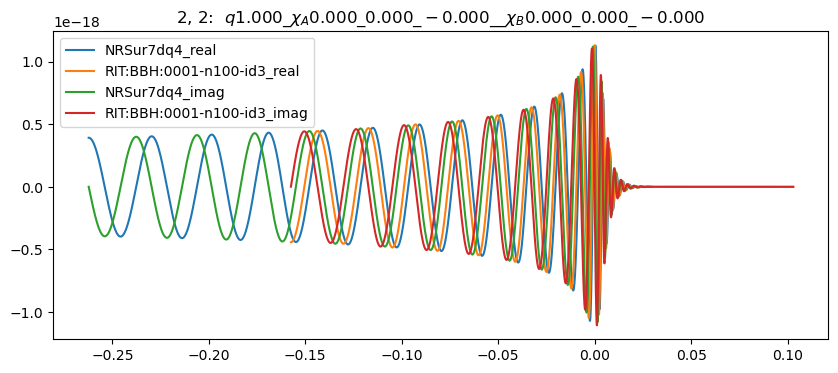

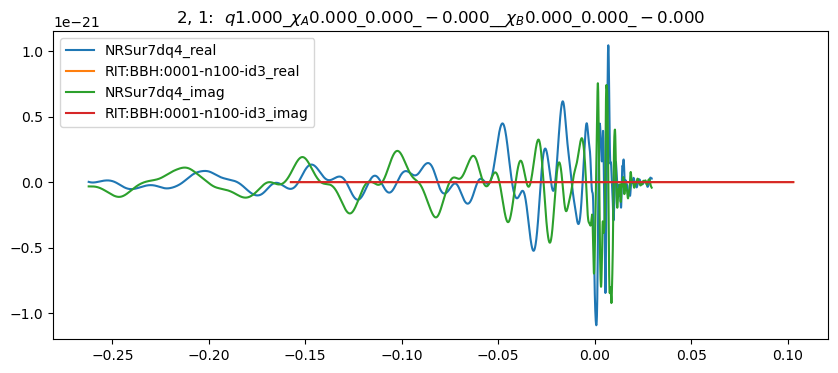

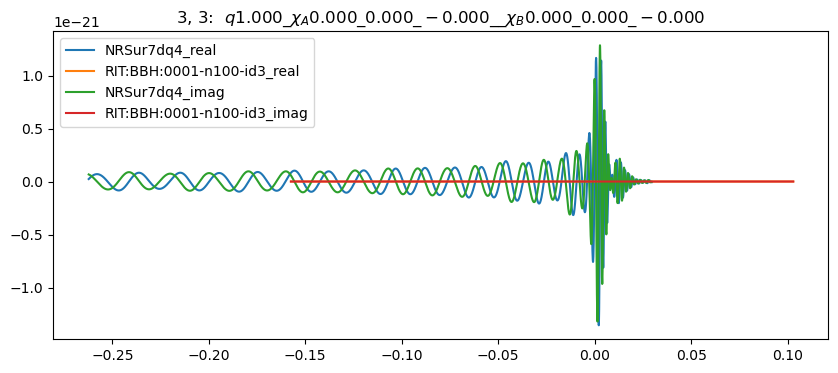

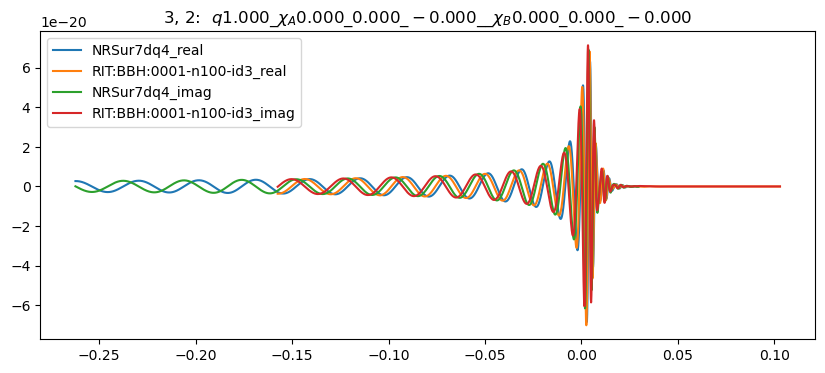

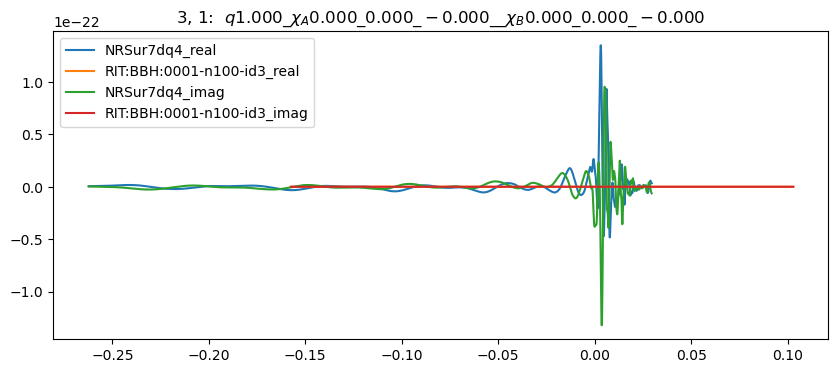

In [16]:
# %matplotlib widget
nonecc_sims = df_rit[df_rit["eccentricity"] < 0.01].index.to_list()
one_sim = nonecc_sims[0]
approx = "NRSur7dq4"
# approx = 'SEOBNRv4PHM'
print(one_sim)

wfm_rit = ritcatalog.get(one_sim)
one_sim_params = ritcatalog.get_parameters(one_sim, total_mass=total_mass)
one_sim_params.update({"f_lower": f_lower, "distance": distance, "delta_t": delta_t})


for el, em in [
    (2, 2),
    (2, 1),
    (3, 3),
    (3, 2),
    (3, 1),
    # (4,4),
    # (4,3),
    # (4,2),
    # (4,1),
]:
    modes = wf.get_td_waveform_modes(
        approximant=approx, coa_phase=np.pi / 2 - 0, **one_sim_params
    )
    if (el, em) not in modes:
        continue
    hp = modes[el, em][0]
    hc = modes[el, em][1]

    modes_rit = wfm_rit.get_mode(
        el,
        em,
        total_mass=total_mass,
        distance=distance,
        # coa_phase=np.pi / 2 - 0,
        delta_t=delta_t,
    )

    sign1 = -1
    sign2 = -1

    plt.figure(figsize=(10, 4))
    plt.title(f"{el}, {em}:  {wfm_rit.label}")
    plt.plot(hp.sample_times, hp, label=approx + "_real")
    plt.plot(
        modes_rit.real().sample_times, sign1 * modes_rit.real(), label=one_sim + "_real"
    )

    plt.plot(hc.sample_times, hc, label=approx + "_imag")
    plt.plot(
        modes_rit.imag().sample_times, sign2 * modes_rit.imag(), label=one_sim + "_imag"
    )
    plt.legend()

2 1 2.479635284921821e-31
3 3 4.807999950149789e-32
3 1 7.998157221320579e-32
4 3 1.5350929038216473e-33
4 1 2.228990739707947e-33


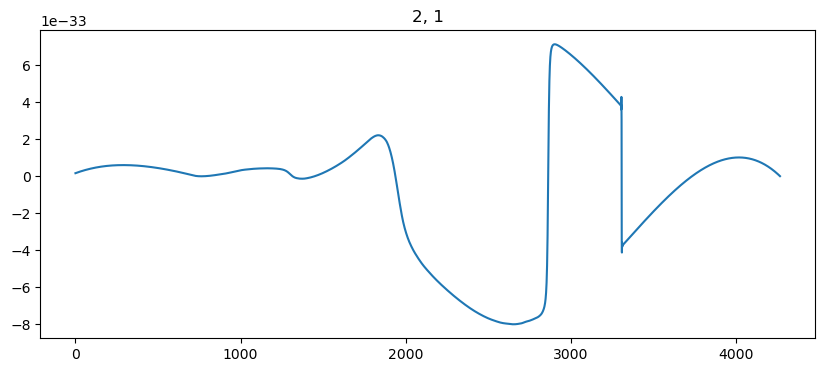

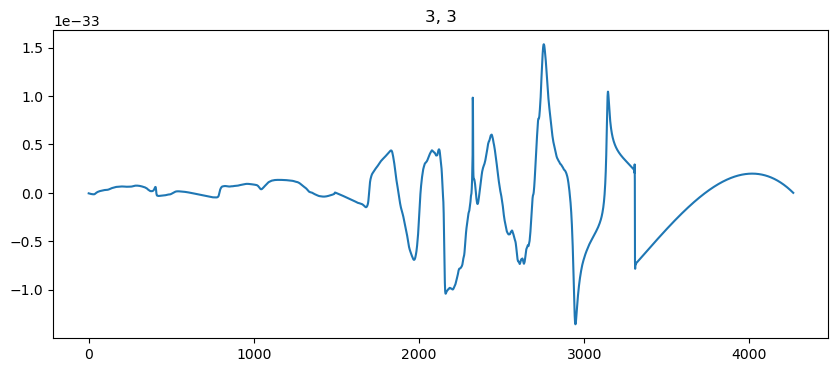

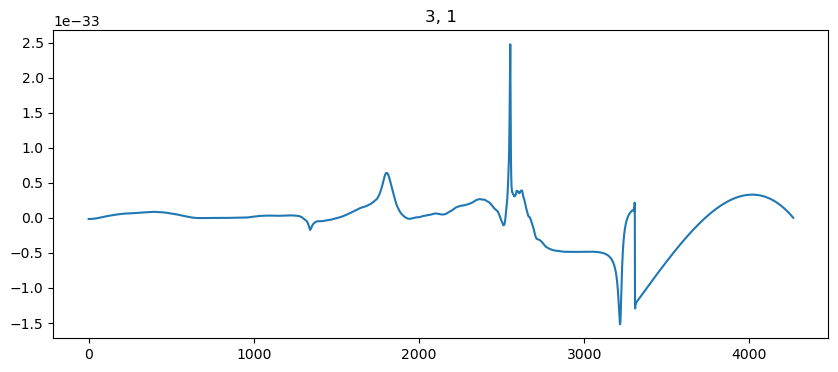

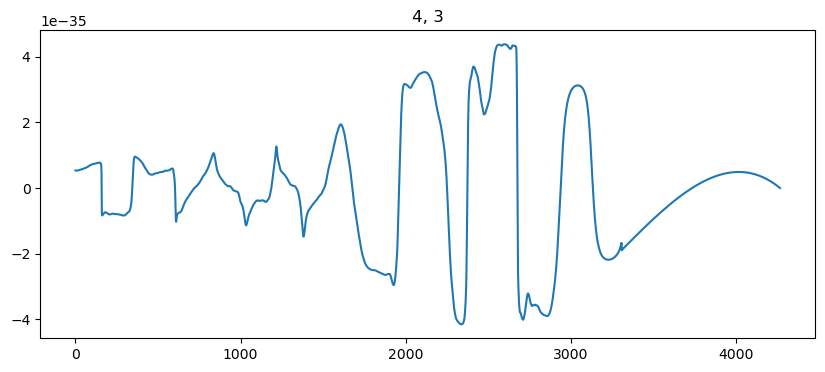

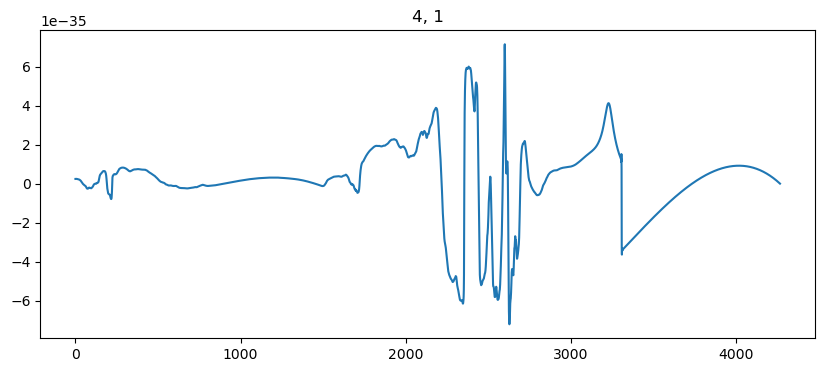

In [17]:
for el, em in [
    (2, 1),
    (3, 3),
    (3, 1),
    (4, 3),
    (4, 1),
]:
    modes_rit = wfm_rit.get_mode(
        el,
        em,
        total_mass=total_mass,
        distance=distance,
        # coa_phase=np.pi / 2 - 0,
        delta_t=delta_t,
    )
    moderms = (
        np.abs(modes_rit.real().data) ** 2 + np.abs(modes_rit.imag().data) ** 2
    ).sum() ** 0.5
    print(el, em, moderms)

    sign1 = -1
    sign2 = -1

    plt.figure(figsize=(10, 4))
    plt.title(f"{el}, {em}")
    plt.plot(
        # modes_rit.real().sample_times,
        sign1 * modes_rit.real(),
        label=one_sim + "_real",
    )

### Examine the norms for all simulations in the RIT catalog

In [12]:
# %matplotlib widget
df_rit_nonecc_sims = df_rit[df_rit["eccentricity"] < 0.01].copy()

all_sims = df_rit["simulation_name"].to_list()
nonecc_sims = df_rit_nonecc_sims["simulation_name"].to_list()

approx = "NRSur7dq4"
# approx = 'SEOBNRv4PHM'
mode_list = [
    (2, 2),
    (2, 1),
    (3, 3),
    (3, 2),
    (3, 1),
    (4, 4),
    (4, 3),
    (4, 2),
    (4, 1),
]

modes_rmsvals_approx = {lm: [] for lm in mode_list}
modes_rmsvals_rit = {lm: [] for lm in mode_list}

In [13]:
# Calculate the norms of each mode for all simulations
def append_zeros_to_rmsvals():
    for el, em in mode_list:
        modes_rmsvals_approx[el, em].append(0)
        modes_rmsvals_rit[el, em].append(0)


for one_sim in tqdm(all_sims):
    try:
        wfm_rit = ritcatalog.get(one_sim)
    except Exception as exc:
        print(f"Skipping {one_sim} as we couldn't fetch its data, message: {exc}\n")
        append_zeros_to_rmsvals()
        continue

    one_sim_params = ritcatalog.get_parameters(one_sim, total_mass=total_mass)
    one_sim_params.update(
        {
            "f_lower": f_lower,
            "distance": distance,
            "eccentricity": 0,
            "delta_t": delta_t,
        }
    )

    try:
        modes = wf.get_td_waveform_modes(
            approximant=approx, coa_phase=np.pi / 2 - 0, **one_sim_params
        )
    except Exception as exc:
        print(f"Skipping {one_sim} due to failure in NRSur, message: {exc}\n")
        append_zeros_to_rmsvals()
        continue

    for el, em in mode_list:
        if (el, em) not in modes:
            modes_rmsvals_approx[el, em].append(0)
            modes_rmsvals_rit[el, em].append(0)
            continue
        hp = modes[el, em][0]
        hc = modes[el, em][1]
        moderms_approx = (np.abs(hp.data) ** 2 + np.abs(hc.data) ** 2).sum() ** 0.5

        try:
            modes_rit = wfm_rit.get_mode(
                el,
                em,
                total_mass=total_mass,
                distance=distance,
                # coa_phase=np.pi / 2 - 0,
                delta_t=delta_t,
            )
        except Exception as exc:
            print(f"Skipping {one_sim} due to mode {el}, {em} not being available\n")
            modes_rmsvals_approx[el, em].append(0)
            modes_rmsvals_rit[el, em].append(0)
            continue

        moderms_rit = (
            np.abs(modes_rit.real().data) ** 2 + np.abs(modes_rit.imag().data) ** 2
        ).sum() ** 0.5

        # Store output
        modes_rmsvals_approx[el, em].append(moderms_approx)
        modes_rmsvals_rit[el, em].append(moderms_rit)

 10%|█         | 195/1879 [01:44<23:05,  1.22it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 6.9961 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error
 10%|█         | 196/1879 [01:44<17:04,  1.64it/s]

Skipping RIT:BBH:0203-n120-id1 due to failure in NRSur, message: Internal function call failed: Input domain error



 14%|█▍        | 267/1879 [02:23<11:34,  2.32it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 6.9947 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error
 14%|█▍        | 268/1879 [02:23<09:09,  2.93it/s]

Skipping RIT:BBH:0275-n100-id1 due to failure in NRSur, message: Internal function call failed: Input domain error



 15%|█▍        | 274/1879 [02:26<13:02,  2.05it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 14.9886 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error
 15%|█▍        | 275/1879 [02:26<10:00,  2.67it/s]

Skipping RIT:BBH:0282-n100-id3 due to failure in NRSur, message: Internal function call failed: Input domain error



 19%|█▉        | 364/1879 [03:09<11:27,  2.20it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 15.0006 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error
 19%|█▉        | 365/1879 [03:09<08:55,  2.82it/s]

Skipping RIT:BBH:0373-n100-id1 due to failure in NRSur, message: Internal function call failed: Input domain error



 22%|██▏       | 407/1879 [03:29<11:39,  2.10it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 7.0000 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error
 22%|██▏       | 408/1879 [03:29<09:01,  2.72it/s]

Skipping RIT:BBH:0416-n140-id1 due to failure in NRSur, message: Internal function call failed: Input domain error



 23%|██▎       | 432/1879 [03:42<12:32,  1.92it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 14.9892 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error


Skipping RIT:BBH:0442-n100-id1 due to failure in NRSur, message: Internal function call failed: Input domain error



 24%|██▍       | 457/1879 [03:55<11:56,  1.99it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 14.9899 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error
 24%|██▍       | 458/1879 [03:55<09:31,  2.49it/s]

Skipping RIT:BBH:0467-n100-id1 due to failure in NRSur, message: Internal function call failed: Input domain error



 25%|██▌       | 474/1879 [04:07<17:12,  1.36it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 6.9994 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error
 25%|██▌       | 475/1879 [04:08<12:52,  1.82it/s]

Skipping RIT:BBH:0484-n100-id1 due to failure in NRSur, message: Internal function call failed: Input domain error



 26%|██▌       | 485/1879 [04:13<15:06,  1.54it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 15.0003 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error
 26%|██▌       | 486/1879 [04:14<11:19,  2.05it/s]

Skipping RIT:BBH:0495-n100-id1 due to failure in NRSur, message: Internal function call failed: Input domain error



 39%|███▉      | 742/1879 [06:19<12:14,  1.55it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 14.9896 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error
 40%|███▉      | 743/1879 [06:20<09:14,  2.05it/s]

Skipping RIT:BBH:0764-n100-id1 due to failure in NRSur, message: Internal function call failed: Input domain error



 41%|████      | 765/1879 [06:31<09:35,  1.94it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 14.9880 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error
 41%|████      | 766/1879 [06:31<07:21,  2.52it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 31.9993 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrece

Skipping RIT:BBH:0791-n100-id1 due to failure in NRSur, message: Internal function call failed: Input domain error

Skipping RIT:BBH:0792-n100-id1 due to failure in NRSur, message: Internal function call failed: Input domain error



 42%|████▏     | 786/1879 [06:42<10:51,  1.68it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 64.0035 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error


Skipping RIT:BBH:0812-n100-id1 due to failure in NRSur, message: Internal function call failed: Input domain error



 44%|████▍     | 835/1879 [07:05<07:51,  2.22it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 6.9975 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error
 44%|████▍     | 836/1879 [07:05<06:01,  2.89it/s]

Skipping RIT:BBH:0865-n100-id1 due to failure in NRSur, message: Internal function call failed: Input domain error



 45%|████▍     | 837/1879 [07:05<06:46,  2.56it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 6.9947 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error
 45%|████▍     | 838/1879 [07:05<05:17,  3.28it/s]

Skipping RIT:BBH:0867-n100-id1 due to failure in NRSur, message: Internal function call failed: Input domain error



 45%|████▍     | 840/1879 [07:06<06:24,  2.70it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 6.9945 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error
 45%|████▍     | 841/1879 [07:06<05:05,  3.40it/s]

Skipping RIT:BBH:0870-n100-id1 due to failure in NRSur, message: Internal function call failed: Input domain error



 45%|████▍     | 844/1879 [07:08<06:44,  2.56it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 14.9894 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error
 45%|████▍     | 845/1879 [07:08<05:26,  3.16it/s]

Skipping RIT:BBH:0874-n100-id1 due to failure in NRSur, message: Internal function call failed: Input domain error



 45%|████▌     | 854/1879 [07:12<08:08,  2.10it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 7.0001 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error
 46%|████▌     | 855/1879 [07:12<06:13,  2.74it/s]

Skipping RIT:BBH:0884-n100-id1 due to failure in NRSur, message: Internal function call failed: Input domain error



 46%|████▌     | 857/1879 [07:13<07:36,  2.24it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 6.9974 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error
 46%|████▌     | 858/1879 [07:13<05:53,  2.89it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 7.0003 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecess

Skipping RIT:BBH:0887-n100-id1 due to failure in NRSur, message: Internal function call failed: Input domain error

Skipping RIT:BBH:0888-n100-id1 due to failure in NRSur, message: Internal function call failed: Input domain error



XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 6.9992 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error
 46%|████▌     | 860/1879 [07:14<03:54,  4.34it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 7.0002 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: I

Skipping RIT:BBH:0889-n100-id1 due to failure in NRSur, message: Internal function call failed: Input domain error

Skipping RIT:BBH:0890-n100-id1 due to failure in NRSur, message: Internal function call failed: Input domain error



 46%|████▌     | 866/1879 [07:16<07:08,  2.36it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 7.0000 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error
 46%|████▌     | 867/1879 [07:16<05:33,  3.03it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 9.9983 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecess

Skipping RIT:BBH:0896-n100-id1 due to failure in NRSur, message: Internal function call failed: Input domain error

Skipping RIT:BBH:0897-n100-id1 due to failure in NRSur, message: Internal function call failed: Input domain error



 46%|████▋     | 873/1879 [07:19<07:02,  2.38it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 9.9938 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error
 47%|████▋     | 874/1879 [07:19<05:27,  3.07it/s]

Skipping RIT:BBH:0903-n100-id1 due to failure in NRSur, message: Internal function call failed: Input domain error



 47%|████▋     | 887/1879 [07:25<07:42,  2.14it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 9.9923 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error
 47%|████▋     | 888/1879 [07:25<05:58,  2.76it/s]

Skipping RIT:BBH:0922-n100-id1 due to failure in NRSur, message: Internal function call failed: Input domain error



 48%|████▊     | 899/1879 [07:30<07:14,  2.26it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 14.9961 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error
 48%|████▊     | 900/1879 [07:30<05:38,  2.89it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 127.9870 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrec

Skipping RIT:BBH:0934-n100-id1 due to failure in NRSur, message: Internal function call failed: Input domain error

Skipping RIT:BBH:0935-n100-id1 due to failure in NRSur, message: Internal function call failed: Input domain error



 48%|████▊     | 902/1879 [07:31<05:29,  2.96it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 31.9990 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error
 48%|████▊     | 903/1879 [07:31<04:26,  3.66it/s]

Skipping RIT:BBH:0937-n120-id1 due to failure in NRSur, message: Internal function call failed: Input domain error



 48%|████▊     | 907/1879 [07:33<06:33,  2.47it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 14.9996 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error
 48%|████▊     | 908/1879 [07:33<05:04,  3.19it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 15.0000 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrece

Skipping RIT:BBH:0942-n120-id1 due to failure in NRSur, message: Internal function call failed: Input domain error

Skipping RIT:BBH:0943-n120-id1 due to failure in NRSur, message: Internal function call failed: Input domain error



 48%|████▊     | 910/1879 [07:33<05:11,  3.11it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 14.9954 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error
 48%|████▊     | 911/1879 [07:33<04:18,  3.74it/s]

Skipping RIT:BBH:0945-n100-id1 due to failure in NRSur, message: Internal function call failed: Input domain error



 49%|████▉     | 923/1879 [07:39<07:17,  2.18it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 10.0006 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error
 49%|████▉     | 924/1879 [07:39<05:35,  2.85it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 10.0005 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrece

Skipping RIT:BBH:0960-n100-id1 due to failure in NRSur, message: Internal function call failed: Input domain error

Skipping RIT:BBH:0961-n100-id1 due to failure in NRSur, message: Internal function call failed: Input domain error



XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 31.9679 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error
 49%|████▉     | 926/1879 [07:39<03:39,  4.34it/s]

Skipping RIT:BBH:0962-n100-id1 due to failure in NRSur, message: Internal function call failed: Input domain error



 49%|████▉     | 930/1879 [07:41<07:12,  2.20it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 31.9969 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error


Skipping RIT:BBH:0967-n100-id1 due to failure in NRSur, message: Internal function call failed: Input domain error



 50%|████▉     | 935/1879 [07:43<06:02,  2.60it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 10.0000 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error
 50%|████▉     | 936/1879 [07:43<04:51,  3.24it/s]

Skipping RIT:BBH:0973-n100-id1 due to failure in NRSur, message: Internal function call failed: Input domain error



 50%|████▉     | 937/1879 [07:44<04:53,  3.21it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 9.9980 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error
 50%|████▉     | 938/1879 [07:44<04:02,  3.87it/s]

Skipping RIT:BBH:0976-n100-id1 due to failure in NRSur, message: Internal function call failed: Input domain error



 50%|████▉     | 939/1879 [07:44<04:30,  3.48it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 10.0002 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error
 50%|█████     | 940/1879 [07:44<03:43,  4.19it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 9.9997 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPreces

Skipping RIT:BBH:0978-n144-id1 due to failure in NRSur, message: Internal function call failed: Input domain error

Skipping RIT:BBH:0979-n100-id1 due to failure in NRSur, message: Internal function call failed: Input domain error



 50%|█████     | 948/1879 [07:47<06:25,  2.42it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 63.9960 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error
 51%|█████     | 949/1879 [07:47<04:57,  3.12it/s]

Skipping RIT:BBH:0988-n100-id1 due to failure in NRSur, message: Internal function call failed: Input domain error



 51%|█████     | 951/1879 [07:48<06:14,  2.48it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 14.9879 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error
 51%|█████     | 952/1879 [07:49<05:00,  3.09it/s]

Skipping RIT:BBH:0991-n100-id1 due to failure in NRSur, message: Internal function call failed: Input domain error



 52%|█████▏    | 976/1879 [07:59<06:01,  2.50it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 31.9976 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error
 52%|█████▏    | 978/1879 [07:59<03:39,  4.11it/s]

Skipping RIT:BBH:1018-n100-id1 due to failure in NRSur, message: Internal function call failed: Input domain error

Skipping RIT:BBH:1019-n120-id1 as we couldn't fetch its data, message: "Unable to open object (object 'X' doesn't exist)"



 52%|█████▏    | 983/1879 [08:01<05:18,  2.81it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 32.0000 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error


Skipping RIT:BBH:1025-n100-id1 due to failure in NRSur, message: Internal function call failed: Input domain error



 55%|█████▍    | 1031/1879 [08:21<06:25,  2.20it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 31.9791 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error
XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 31.9969 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed

Skipping RIT:BBH:1074-n100-id1 due to failure in NRSur, message: Internal function call failed: Input domain error

Skipping RIT:BBH:1075-n100-id1 due to failure in NRSur, message: Internal function call failed: Input domain error



XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 127.9920 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error


Skipping RIT:BBH:1076-n100-id1 due to failure in NRSur, message: Internal function call failed: Input domain error



 56%|█████▌    | 1044/1879 [08:26<06:55,  2.01it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 31.9713 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error
 56%|█████▌    | 1045/1879 [08:26<05:23,  2.58it/s]

Skipping RIT:BBH:1089-n100-id1 due to failure in NRSur, message: Internal function call failed: Input domain error



 79%|███████▊  | 1477/1879 [11:57<03:10,  2.11it/s]

Skipping RIT:eBBH:1522-n100-ecc as we couldn't fetch its data, message: Unable to open file (truncated file: eof = 606208, sblock->base_addr = 0, stored_eof = 1071656)



 81%|████████  | 1515/1879 [12:12<02:17,  2.65it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 7.0001 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error
 81%|████████  | 1516/1879 [12:13<02:43,  2.23it/s]

Skipping RIT:eBBH:1560-n100-ecc due to failure in NRSur, message: Internal function call failed: Input domain error



XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 7.0000 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error
 81%|████████  | 1517/1879 [12:13<02:19,  2.59it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 7.0000 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: 

Skipping RIT:eBBH:1561-n100-ecc due to failure in NRSur, message: Internal function call failed: Input domain error

Skipping RIT:eBBH:1562-n100-ecc due to failure in NRSur, message: Internal function call failed: Input domain error



XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 7.0000 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error
 81%|████████  | 1519/1879 [12:13<01:37,  3.68it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 7.0000 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: 

Skipping RIT:eBBH:1563-n100-ecc due to failure in NRSur, message: Internal function call failed: Input domain error

Skipping RIT:eBBH:1564-n100-ecc due to failure in NRSur, message: Internal function call failed: Input domain error



XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 7.0000 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error
 81%|████████  | 1521/1879 [12:14<01:12,  4.91it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 7.0000 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: 

Skipping RIT:eBBH:1565-n100-ecc due to failure in NRSur, message: Internal function call failed: Input domain error

Skipping RIT:eBBH:1566-n100-ecc due to failure in NRSur, message: Internal function call failed: Input domain error



XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 7.0000 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error
 81%|████████  | 1523/1879 [12:14<00:59,  6.00it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 7.0000 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: 

Skipping RIT:eBBH:1567-n100-ecc due to failure in NRSur, message: Internal function call failed: Input domain error

Skipping RIT:eBBH:1568-n100-ecc due to failure in NRSur, message: Internal function call failed: Input domain error



XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 7.0000 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error
 81%|████████  | 1525/1879 [12:14<00:51,  6.94it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 7.0000 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: 

Skipping RIT:eBBH:1569-n100-ecc due to failure in NRSur, message: Internal function call failed: Input domain error

Skipping RIT:eBBH:1570-n100-ecc due to failure in NRSur, message: Internal function call failed: Input domain error



XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 7.0001 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error
 81%|████████▏ | 1527/1879 [12:15<00:46,  7.58it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 7.0000 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: 

Skipping RIT:eBBH:1571-n100-ecc due to failure in NRSur, message: Internal function call failed: Input domain error

Skipping RIT:eBBH:1572-n100-ecc due to failure in NRSur, message: Internal function call failed: Input domain error



XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 7.0000 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error
 81%|████████▏ | 1529/1879 [12:15<00:45,  7.72it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 7.0000 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: 

Skipping RIT:eBBH:1573-n100-ecc due to failure in NRSur, message: Internal function call failed: Input domain error

Skipping RIT:eBBH:1574-n100-ecc due to failure in NRSur, message: Internal function call failed: Input domain error



XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 7.0000 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error
 81%|████████▏ | 1531/1879 [12:15<00:44,  7.77it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 7.0000 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: 

Skipping RIT:eBBH:1575-n100-ecc due to failure in NRSur, message: Internal function call failed: Input domain error

Skipping RIT:eBBH:1576-n100-ecc due to failure in NRSur, message: Internal function call failed: Input domain error



XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 7.0000 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error
 82%|████████▏ | 1533/1879 [12:15<00:44,  7.84it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 7.0000 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: 

Skipping RIT:eBBH:1577-n100-ecc due to failure in NRSur, message: Internal function call failed: Input domain error

Skipping RIT:eBBH:1578-n100-ecc due to failure in NRSur, message: Internal function call failed: Input domain error



XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 7.0000 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error
 82%|████████▏ | 1535/1879 [12:16<00:44,  7.66it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 7.0000 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: 

Skipping RIT:eBBH:1579-n100-ecc due to failure in NRSur, message: Internal function call failed: Input domain error

Skipping RIT:eBBH:1580-n100-ecc due to failure in NRSur, message: Internal function call failed: Input domain error




XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error
 82%|████████▏ | 1537/1879 [12:16<00:39,  8.62it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 7.0000 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error
 82%|████████▏ | 1538/1879 [12:16<00:38,  8.87it/s]

Skipping RIT:eBBH:1581-n100-ecc due to failure in NRSur, message: Internal function call failed: Input domain error

Skipping RIT:eBBH:1582-n100-ecc due to failure in NRSur, message: Internal function call failed: Input domain error



XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 15.0000 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error
 82%|████████▏ | 1539/1879 [12:16<00:38,  8.72it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 15.0005 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed

Skipping RIT:eBBH:1583-n100-ecc due to failure in NRSur, message: Internal function call failed: Input domain error

Skipping RIT:eBBH:1584-n100-ecc due to failure in NRSur, message: Internal function call failed: Input domain error



XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 14.9999 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error
 82%|████████▏ | 1541/1879 [12:16<00:37,  8.91it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 15.0001 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed

Skipping RIT:eBBH:1585-n100-ecc due to failure in NRSur, message: Internal function call failed: Input domain error

Skipping RIT:eBBH:1586-n100-ecc due to failure in NRSur, message: Internal function call failed: Input domain error



XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 15.0002 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error
 82%|████████▏ | 1543/1879 [12:16<00:41,  8.02it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 15.0001 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed

Skipping RIT:eBBH:1587-n100-ecc due to failure in NRSur, message: Internal function call failed: Input domain error

Skipping RIT:eBBH:1588-n100-ecc due to failure in NRSur, message: Internal function call failed: Input domain error



XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 15.0002 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error
 82%|████████▏ | 1545/1879 [12:17<00:43,  7.76it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 15.0001 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed

Skipping RIT:eBBH:1589-n100-ecc due to failure in NRSur, message: Internal function call failed: Input domain error

Skipping RIT:eBBH:1590-n100-ecc due to failure in NRSur, message: Internal function call failed: Input domain error



XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 15.0001 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error
 82%|████████▏ | 1547/1879 [12:17<00:43,  7.62it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 32.0000 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed

Skipping RIT:eBBH:1591-n100-ecc due to failure in NRSur, message: Internal function call failed: Input domain error

Skipping RIT:eBBH:1592-n100-ecc due to failure in NRSur, message: Internal function call failed: Input domain error



XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 32.0007 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error
 82%|████████▏ | 1549/1879 [12:17<00:42,  7.78it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 31.9989 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed

Skipping RIT:eBBH:1593-n100-ecc due to failure in NRSur, message: Internal function call failed: Input domain error

Skipping RIT:eBBH:1594-n100-ecc due to failure in NRSur, message: Internal function call failed: Input domain error



XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 31.9986 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error
 83%|████████▎ | 1551/1879 [12:18<00:42,  7.64it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 32.0008 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed

Skipping RIT:eBBH:1595-n100-ecc due to failure in NRSur, message: Internal function call failed: Input domain error

Skipping RIT:eBBH:1596-n100-ecc due to failure in NRSur, message: Internal function call failed: Input domain error



XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 32.0009 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error
 83%|████████▎ | 1553/1879 [12:18<00:43,  7.49it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 32.0003 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed

Skipping RIT:eBBH:1597-n100-ecc due to failure in NRSur, message: Internal function call failed: Input domain error

Skipping RIT:eBBH:1598-n100-ecc due to failure in NRSur, message: Internal function call failed: Input domain error



XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 32.0002 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error
 83%|████████▎ | 1555/1879 [12:18<00:42,  7.59it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 32.0003 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed

Skipping RIT:eBBH:1599-n100-ecc due to failure in NRSur, message: Internal function call failed: Input domain error

Skipping RIT:eBBH:1600-n100-ecc due to failure in NRSur, message: Internal function call failed: Input domain error



 84%|████████▎ | 1570/1879 [12:24<01:52,  2.74it/s]

..As data does not exist in cache:  (in /home/prayush/.cache/RIT/data/ExtrapStrain_RIT-eBBH-1615-n100.h5),
..we will now download it from https://ccrgpages.rit.edu/~RITCatalog//Data//ExtrapStrain_RIT-eBBH-1615-n100.h5
...writing to cache: /home/prayush/.cache/RIT/data/ExtrapStrain_RIT-eBBH-1615-n100.h5


 84%|████████▎ | 1571/1879 [12:24<02:45,  1.86it/s]

... ... but couldnt find link: https://ccrgpages.rit.edu/~RITCatalog//Data//ExtrapStrain_RIT-eBBH-1615-n100.h5
Skipping RIT:eBBH:1615-n100-ecc as we couldn't fetch its data, message: Could not use or open /home/prayush/.cache/RIT/data/ExtrapStrain_RIT-eBBH-1615-n100.h5

..As data does not exist in cache:  (in /home/prayush/.cache/RIT/data/ExtrapStrain_RIT-eBBH-1616-n100.h5),
..we will now download it from https://ccrgpages.rit.edu/~RITCatalog//Data//ExtrapStrain_RIT-eBBH-1616-n100.h5
...writing to cache: /home/prayush/.cache/RIT/data/ExtrapStrain_RIT-eBBH-1616-n100.h5


 84%|████████▎ | 1572/1879 [12:25<03:20,  1.53it/s]

... ... but couldnt find link: https://ccrgpages.rit.edu/~RITCatalog//Data//ExtrapStrain_RIT-eBBH-1616-n100.h5
Skipping RIT:eBBH:1616-n100-ecc as we couldn't fetch its data, message: Could not use or open /home/prayush/.cache/RIT/data/ExtrapStrain_RIT-eBBH-1616-n100.h5

..As data does not exist in cache:  (in /home/prayush/.cache/RIT/data/ExtrapStrain_RIT-eBBH-1617-n100.h5),
..we will now download it from https://ccrgpages.rit.edu/~RITCatalog//Data//ExtrapStrain_RIT-eBBH-1617-n100.h5
...writing to cache: /home/prayush/.cache/RIT/data/ExtrapStrain_RIT-eBBH-1617-n100.h5


 84%|████████▎ | 1573/1879 [12:27<04:12,  1.21it/s]

... ... but couldnt find link: https://ccrgpages.rit.edu/~RITCatalog//Data//ExtrapStrain_RIT-eBBH-1617-n100.h5
Skipping RIT:eBBH:1617-n100-ecc as we couldn't fetch its data, message: Could not use or open /home/prayush/.cache/RIT/data/ExtrapStrain_RIT-eBBH-1617-n100.h5

..As data does not exist in cache:  (in /home/prayush/.cache/RIT/data/ExtrapStrain_RIT-eBBH-1618-n100.h5),
..we will now download it from https://ccrgpages.rit.edu/~RITCatalog//Data//ExtrapStrain_RIT-eBBH-1618-n100.h5
...writing to cache: /home/prayush/.cache/RIT/data/ExtrapStrain_RIT-eBBH-1618-n100.h5


 84%|████████▍ | 1574/1879 [12:28<04:29,  1.13it/s]

... ... but couldnt find link: https://ccrgpages.rit.edu/~RITCatalog//Data//ExtrapStrain_RIT-eBBH-1618-n100.h5
Skipping RIT:eBBH:1618-n100-ecc as we couldn't fetch its data, message: Could not use or open /home/prayush/.cache/RIT/data/ExtrapStrain_RIT-eBBH-1618-n100.h5

..As data does not exist in cache:  (in /home/prayush/.cache/RIT/data/ExtrapStrain_RIT-eBBH-1619-n100.h5),
..we will now download it from https://ccrgpages.rit.edu/~RITCatalog//Data//ExtrapStrain_RIT-eBBH-1619-n100.h5
...writing to cache: /home/prayush/.cache/RIT/data/ExtrapStrain_RIT-eBBH-1619-n100.h5


 84%|████████▍ | 1575/1879 [12:29<04:45,  1.06it/s]

... ... but couldnt find link: https://ccrgpages.rit.edu/~RITCatalog//Data//ExtrapStrain_RIT-eBBH-1619-n100.h5
Skipping RIT:eBBH:1619-n100-ecc as we couldn't fetch its data, message: Could not use or open /home/prayush/.cache/RIT/data/ExtrapStrain_RIT-eBBH-1619-n100.h5

..As data does not exist in cache:  (in /home/prayush/.cache/RIT/data/ExtrapStrain_RIT-eBBH-1620-n100.h5),
..we will now download it from https://ccrgpages.rit.edu/~RITCatalog//Data//ExtrapStrain_RIT-eBBH-1620-n100.h5
...writing to cache: /home/prayush/.cache/RIT/data/ExtrapStrain_RIT-eBBH-1620-n100.h5


 84%|████████▍ | 1576/1879 [12:30<04:57,  1.02it/s]

... ... but couldnt find link: https://ccrgpages.rit.edu/~RITCatalog//Data//ExtrapStrain_RIT-eBBH-1620-n100.h5
Skipping RIT:eBBH:1620-n100-ecc as we couldn't fetch its data, message: Could not use or open /home/prayush/.cache/RIT/data/ExtrapStrain_RIT-eBBH-1620-n100.h5



100%|█████████▉| 1871/1879 [14:35<00:03,  2.17it/s]XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Too much extrapolation. Mass ratio q = 63.9946 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (LALSimIMRPrecessingNRSur.c:1702): Input domain error
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Failed to integrate dynamics
XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1862): Internal function call failed: Input domain error
100%|█████████▉| 1872/1879 [14:35<00:02,  2.80it/s]

Skipping RIT:BBH:1916-n100-id1 due to failure in NRSur, message: Internal function call failed: Input domain error



100%|██████████| 1879/1879 [14:39<00:00,  2.14it/s]


In [14]:
# Store the norms to disk with metadata
for el, em in mode_list:
    tag = f"norm_of_Y_l{el:d}_m{em:d}"
    if tag not in df_rit:
        df_rit[tag] = modes_rmsvals_rit[el, em]

    tag = f"norm_of_{approx}_Y_l{el:d}_m{em:d}"
    if tag not in df_rit:
        df_rit[tag] = modes_rmsvals_rit[el, em]

ritcatalog.write_metadata_df_to_disk()

<Axes: >

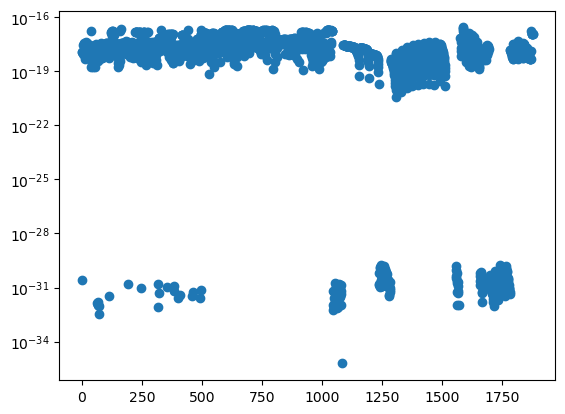

In [15]:
df_rit["norm_of_Y_l2_m1"].plot(style="o", grid=False, logy=True)

/tmp/ipykernel_1295164/468855330.py:5: RuntimeWarning: divide by zero encountered in log10
  np.log10(norms),


ValueError: supplied range of [-inf, -16.104922944174522] is not finite

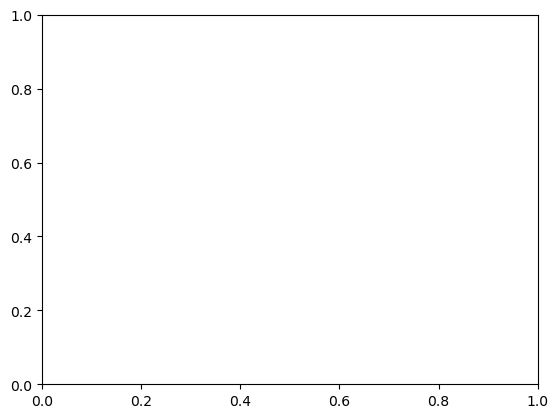

In [16]:
for el, em in mode_list:
    tag = f"norm_of_Y_l{el:d}_m{em:d}"
    norms = df_rit[tag].to_list()
    _ = plt.hist(
        np.log10(norms),
        label=f"RIT",
        bins=20,
        density=False,
        cumulative=False,
        alpha=0.5,
        log=True,
    )
    tag = f"norm_of_{approx}_Y_l{el:d}_m{em:d}"
    norms = df_rit[tag].to_list()
    _ = plt.hist(
        np.log10(norms),
        label=f"{approx}",
        bins=20,
        density=False,
        cumulative=False,
        alpha=0.5,
        log=True,
    )
    plt.xlabel("$Log_{10}(||h_{" + str(lm[0]) + "," + str(lm[1]) + "}||)$")
    plt.legend()

100%|██████████| 9/9 [00:00<00:00, 27.05it/s]


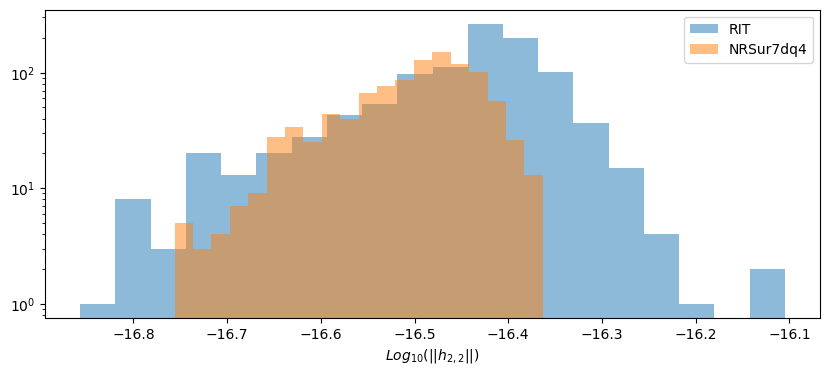

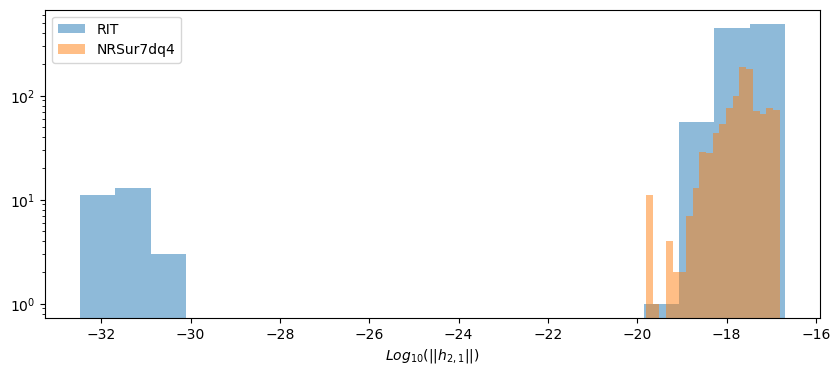

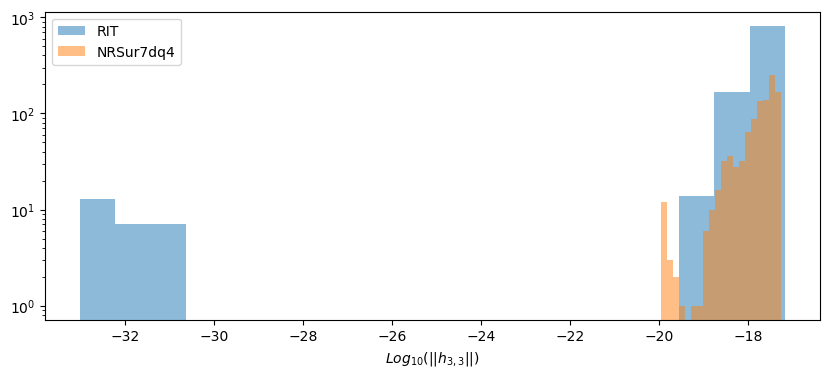

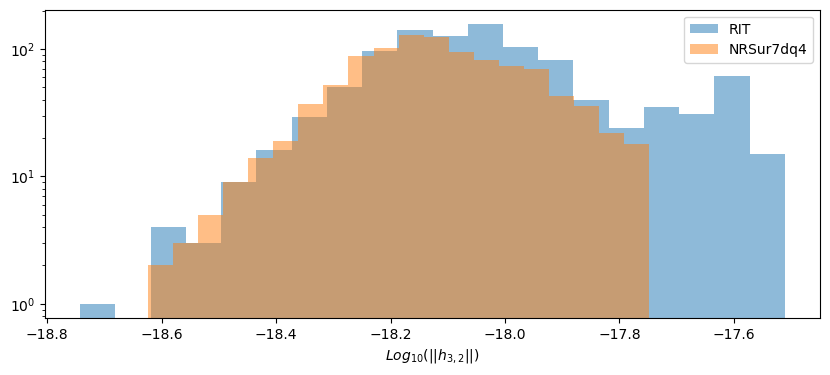

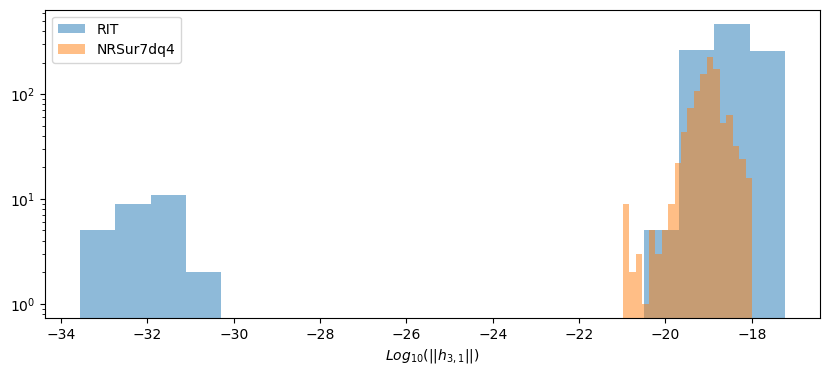

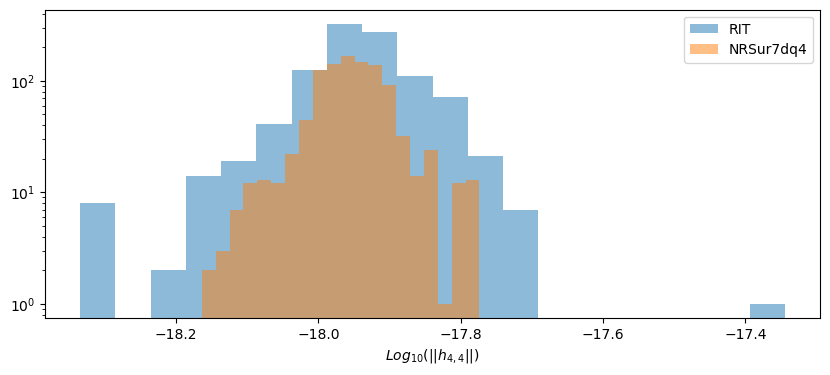

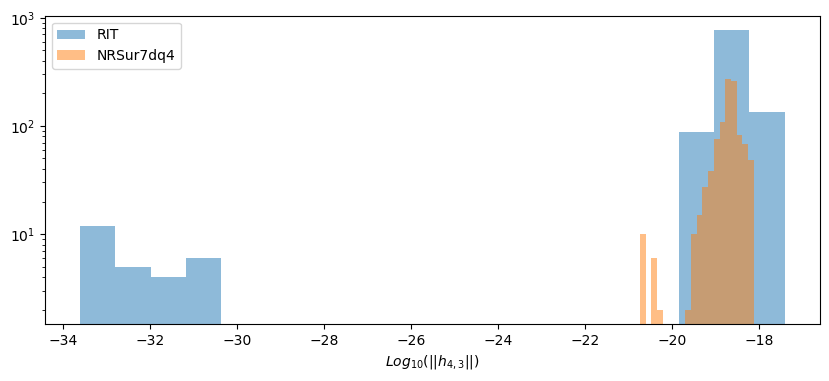

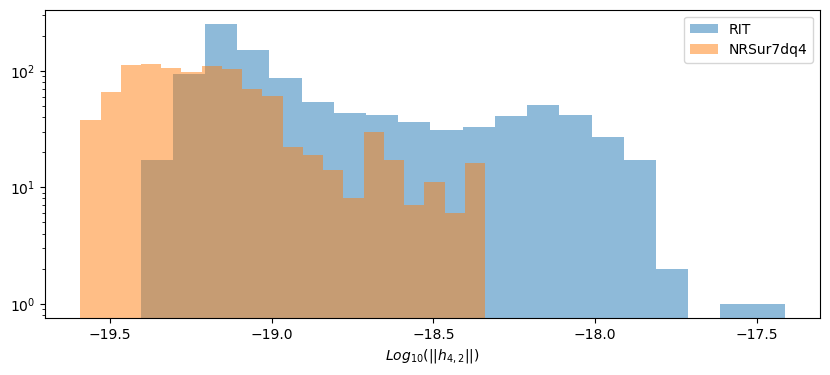

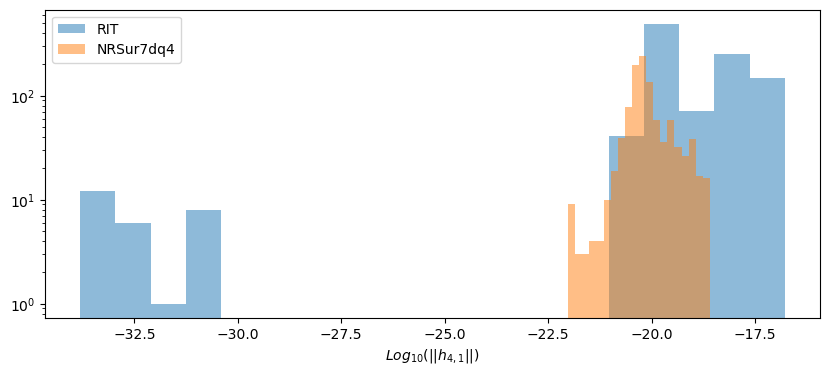

In [ ]:
for lm in tqdm(modes_rmsvals_rit):
    norms = np.array(list(modes_rmsvals_rit[lm].values()))
    norms_approx = np.array(list(modes_rmsvals_approx[lm].values()))

    plt.figure(figsize=(10, 4))
    # plt.title(f"{lm[0]}, {lm[1]}")
    _ = plt.hist(
        np.log10(norms),
        label=f"RIT",
        bins=20,
        density=False,
        cumulative=False,
        alpha=0.5,
        log=True,
    )
    _ = plt.hist(
        np.log10(norms_approx),
        label=f"{approx}",
        bins=20,
        density=False,
        cumulative=False,
        alpha=0.5,
        log=True,
    )
    plt.xlabel("$Log_{10}(||h_{" + str(lm[0]) + "," + str(lm[1]) + "}||)$")

    plt.legend()

## $\Psi_4$ modes

### Let us examine one simulation in detail

In [6]:
nonecc_sims = df_rit[df_rit["eccentricity"] < 0.01].index.to_list()

In [7]:
one_sim = nonecc_sims[4]
print(one_sim)
one_sim_params = ritcatalog.get_parameters(one_sim, total_mass=total_mass)
one_sim_params.update({"f_lower": f_lower, "distance": distance, "delta_t": delta_t})

RIT:BBH:0005-n100-id0


In [8]:
one_sim_params["mass1"] / one_sim_params["mass2"]

2.9994684067777593

[-1.26861014e-20 -1.36564137e-20 -1.46250149e-20 ... -3.31637086e-22
 -3.33305920e-22 -3.32824725e-22]


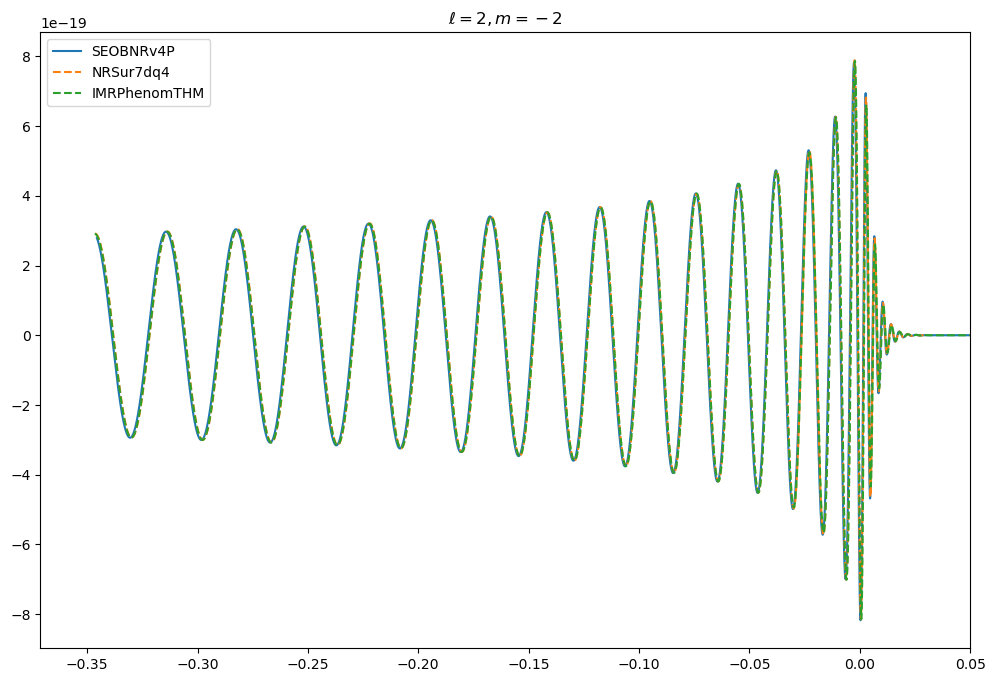

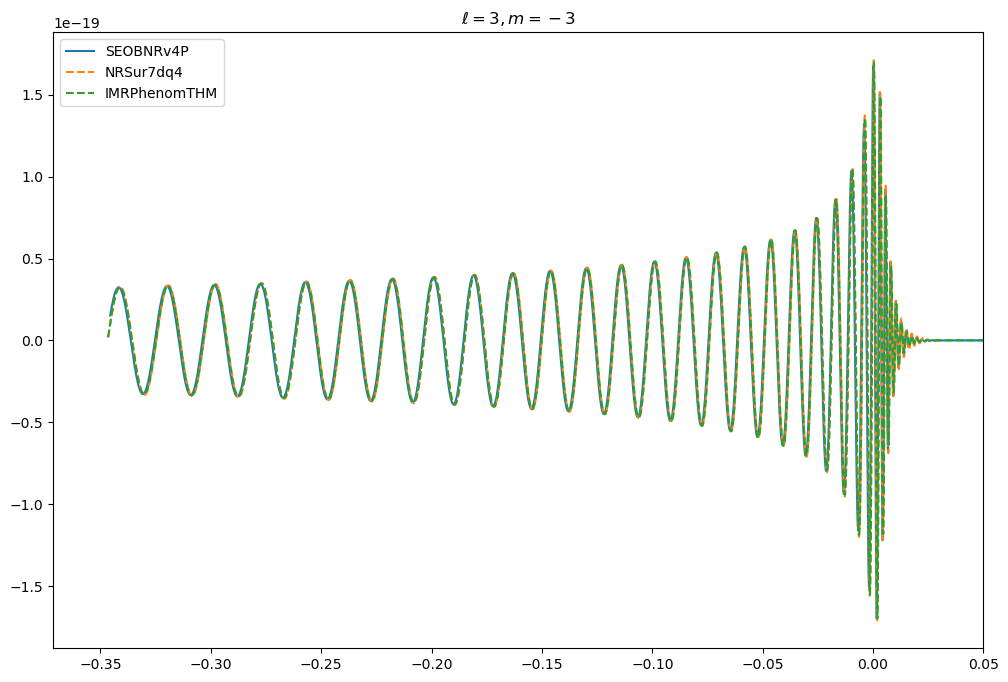

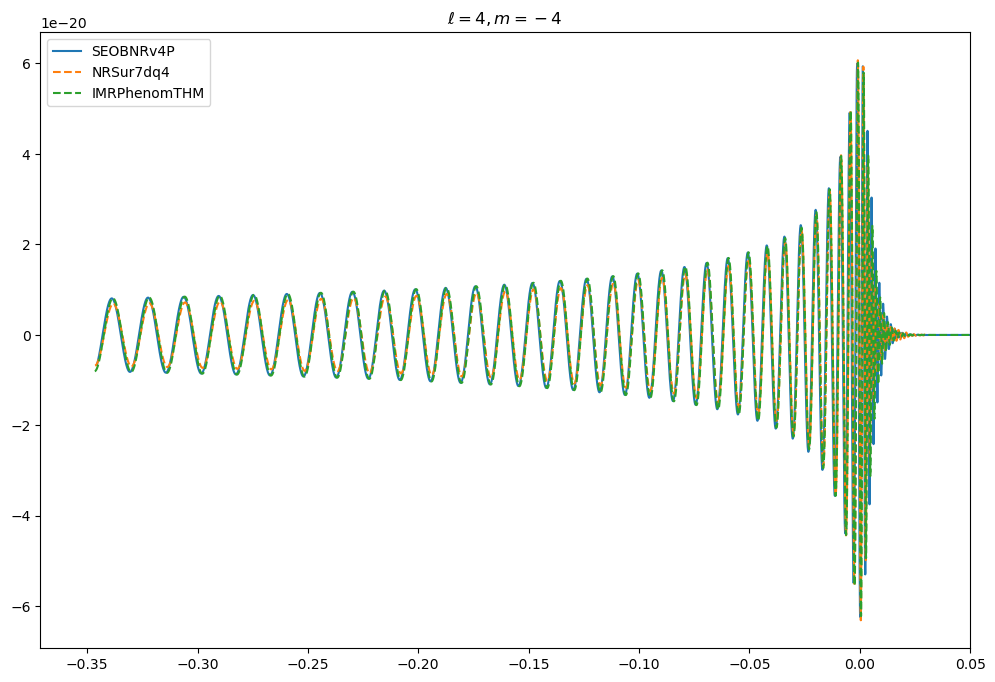

In [13]:
modes1 = wf.get_td_waveform_modes(
    approximant="SEOBNRv4PHM", coa_phase=coa_phase, **one_sim_params
)
modes2 = wf.get_td_waveform_modes(
    approximant="NRSur7dq4", coa_phase=coa_phase, **one_sim_params
)
modes3 = wf.get_td_waveform_modes(
    approximant="IMRPhenomTPHM", coa_phase=coa_phase, **one_sim_params
)

for ellem in [(2, -2), (3, -3), (4, -4)]:
    plt.figure(figsize=(12, 8))
    plt.plot(modes1[ellem][0].sample_times, modes1[ellem][0], label="SEOBNRv4P")
    plt.plot(modes2[ellem][0].sample_times, modes2[ellem][0], "--", label="NRSur7dq4")
    plt.plot(
        modes3[ellem][0].sample_times, modes3[ellem][0], "--", label="IMRPhenomTHM"
    )
    plt.xlim(xmax=0.05)
    plt.legend()
    plt.title(f"$\ell={ellem[0]}, m={ellem[1]}$")

print(modes1[2, 2][0].data[: len(modes2[2, 2][0].data)] - modes2[2, 2][0].data)

In [9]:
md = ritcatalog.get_metadata(one_sim)
md

Metadata([('Unnamed__0', 4),
          ('catalog_tag', 'RIT:BBH:0005'),
          ('resolution_tag', 'n100'),
          ('id_tag', 'id0'),
          ('run_name', 'U0_D9.07_q3.00_a0.66667_n100'),
          ('data_type', 'NR'),
          ('system_type', 'Aligned'),
          ('comments', 'none'),
          ('authors_emails',
           'James Healy <jchsma@rit.edu>, Carlos Lousto <colsma@rit.edu>'),
          ('simulation_bibtex_keys',
           'Healy:2014yta, Healy:2016lce, Healy:2018swt'),
          ('code_bibtex_keys', 'Campanelli:2005dd'),
          ('initial_data_bibtex_keys',
           'Bowen:1980yu, Brandt:1997tf, Ansorg:2004ds'),
          ('quasicircular_bibtex_keys', 'Husa:2007rh, Buonanno:2010yk'),
          ('eccentricity_bibtex_keys', 'Campanelli:2008nk'),
          ('extrapolation_bibtex_keys', 'Nakano:2015pta'),
          ('code', 'LazEv'),
          ('evolution_system', 'BSSN'),
          ('evolution_gauge', '1+log/Gamma-driver(eta=2.0)'),
          ('cfl', 0.25),
    

In [11]:
nrcatalogtools.WaveformModes.load_from_targz(md.psi4_data_location, verbosity=1)

Shape of mode_data[3, 3] is (6397, 6)
Shape of mode_data[4, -3] is (6397, 6)
Shape of mode_data[4, 4] is (6397, 6)
Shape of mode_data[3, -2] is (6397, 6)
Shape of mode_data[3, 1] is (6397, 6)
Shape of mode_data[4, -1] is (6397, 6)
Shape of mode_data[2, 2] is (6397, 6)
Shape of mode_data[4, 1] is (6397, 6)
Shape of mode_data[2, 1] is (6397, 6)
Shape of mode_data[2, 0] is (6397, 6)
Shape of mode_data[4, 2] is (6397, 6)
Shape of mode_data[3, -3] is (6397, 6)
Shape of mode_data[4, -4] is (6397, 6)
Shape of mode_data[3, 0] is (6397, 6)
Shape of mode_data[4, 3] is (6397, 6)
Shape of mode_data[3, 2] is (6397, 6)
Shape of mode_data[2, -2] is (6397, 6)
Shape of mode_data[2, -1] is (6397, 6)
Shape of mode_data[4, 0] is (6397, 6)
Shape of mode_data[3, -1] is (6397, 6)
Shape of mode_data[4, -2] is (6397, 6)


WaveformModes([[-3.49461340e-05-1.37192263e-04j, -5.85421648e-06-9.29910021e-06j,
         1.42842401e-06-1.99056331e-17j, ...,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j],
       [ 8.90484341e-07-3.35908411e-06j, -2.08942571e-09-2.42992271e-08j,
        -3.78366484e-08-3.97190131e-18j, ...,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j],
       [ 9.04726206e-07-3.33506824e-06j, -2.01194020e-09-2.44642926e-08j,
        -4.32418567e-08-7.72131553e-18j, ...,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j],
       ...,
       [ 9.13231113e-07-1.73567103e-07j,  5.76836368e-08-4.27131234e-07j,
        -5.01390184e-07+3.83903988e-17j, ...,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j],
       [ 9.49820065e-07-1.17884023e-

RIT:BBH:0005-n100-id0
shrinking NRSur7dq4 waveform
6161 6161
6161 6161
shrinking NRSur7dq4 waveform
6161 6161
6161 6161
shrinking NRSur7dq4 waveform
6161 6161
6161 6161
shrinking NRSur7dq4 waveform
6161 6161
6161 6161
shrinking NRSur7dq4 waveform
6161 6161
6161 6161


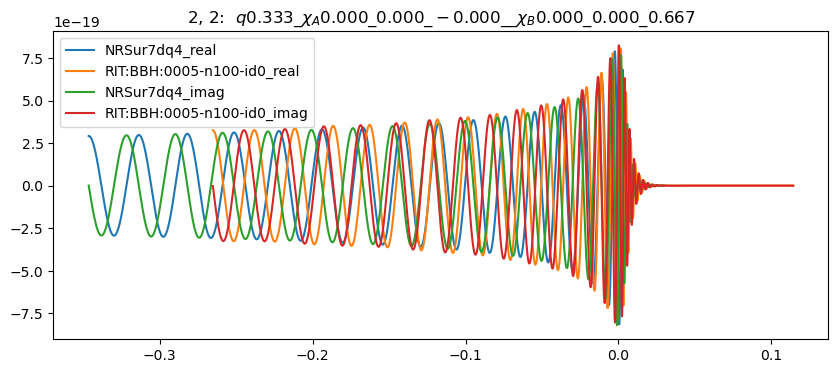

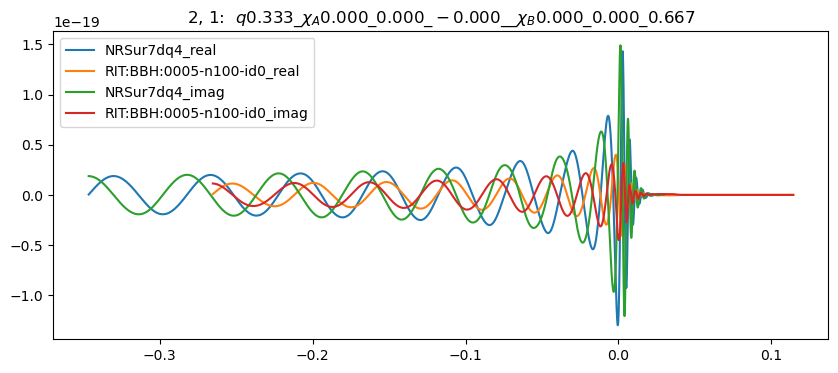

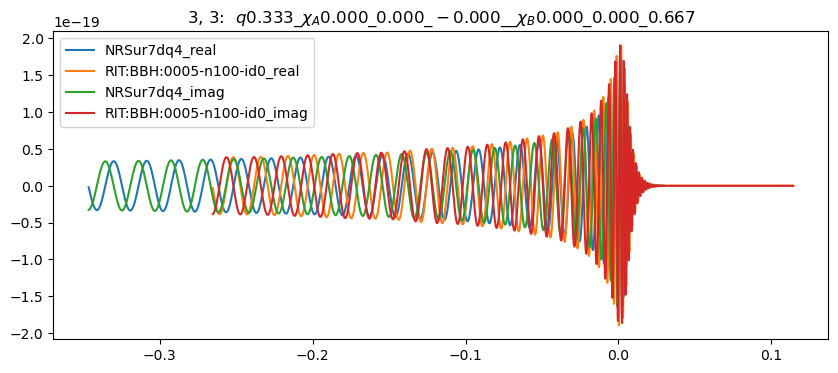

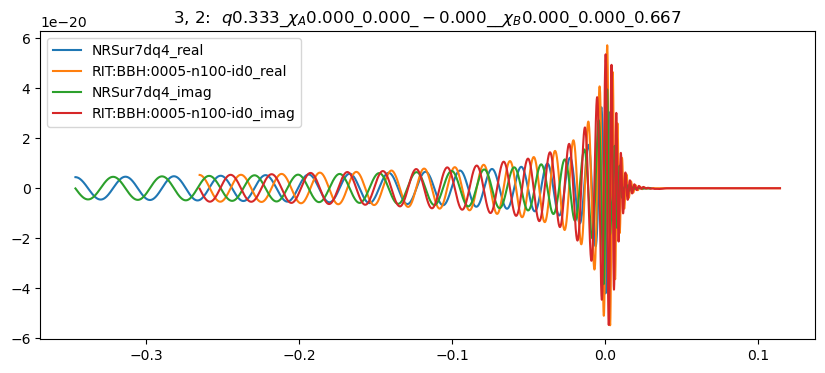

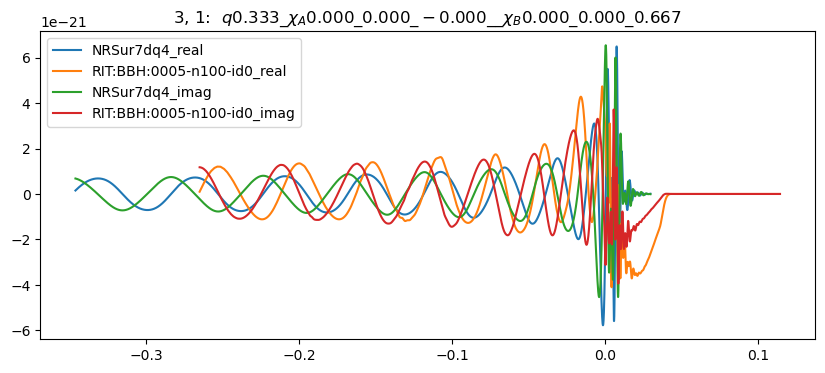

In [56]:
# %matplotlib widget
nonecc_sims = df_rit[df_rit["eccentricity"] < 0.01].index.to_list()
one_sim = nonecc_sims[4]
approx = "NRSur7dq4"
# approx = 'SEOBNRv4PHM'
print(one_sim)

wfm_rit = ritcatalog.get(one_sim)
one_sim_params = ritcatalog.get_parameters(one_sim, total_mass=total_mass)
one_sim_params.update({"f_lower": f_lower, "distance": distance, "delta_t": delta_t})


for el, em in [
    (2, 2),
    (2, 1),
    (3, 3),
    (3, 2),
    (3, 1),
    # (4,4),
    # (4,3),
    # (4,2),
    # (4,1),
]:
    modes = wf.get_td_waveform_modes(
        approximant=approx, coa_phase=np.pi / 2 - 0, **one_sim_params
    )
    if (el, em) not in modes:
        continue
    hp = modes[el, em][0]
    hc = modes[el, em][1]

    modes_rit = wfm_rit.get_mode(
        el,
        em,
        total_mass=total_mass,
        distance=distance,
        # coa_phase=np.pi / 2 - 0,
        delta_t=delta_t,
    )
    modes_rit_real = modes_rit.real()
    modes_rit_imag = modes_rit.imag()

    sign1 = 1
    sign2 = 1

    deltaT_idx = int(
        abs(hp.sample_times[0] - modes_rit.real().sample_times[0]) * hp.delta_t
    )
    if hp.sample_times[0] < modes_rit_real.sample_times[0]:
        print(f"shrinking {approx} waveform by {deltaT_}")
        print(len(hp), len(hc))
        hp = hp[deltaT_idx:]
        hc = hc[deltaT_idx:]
        print(len(hp), len(hc))
    else:
        print(f"shrinking RIT waveform")
        modes_rit_real = modes_rit_real[deltaT_idx:]
        modes_rit_imag = modes_rit_imag[deltaT_idx:]

    # hp, modes_rit_real = wf.coalign_waveforms(hp, modes_rit.real())
    # hc, modes_rit_imag = wf.coalign_waveforms(hc, modes_rit.imag())

    plt.figure(figsize=(10, 4))
    plt.title(f"{el}, {em}:  {wfm_rit.label}")
    plt.plot(hp.sample_times, hp, label=approx + "_real")
    plt.plot(
        modes_rit_real.sample_times, sign1 * modes_rit_real, label=one_sim + "_real"
    )

    plt.plot(hc.sample_times, hc, label=approx + "_imag")
    plt.plot(
        modes_rit_imag.sample_times, sign2 * modes_rit_imag, label=one_sim + "_imag"
    )
    plt.legend()

2 1 2.479635284921821e-31
3 3 4.807999950149789e-32
3 1 7.998157221320579e-32
4 3 1.5350929038216473e-33
4 1 2.228990739707947e-33


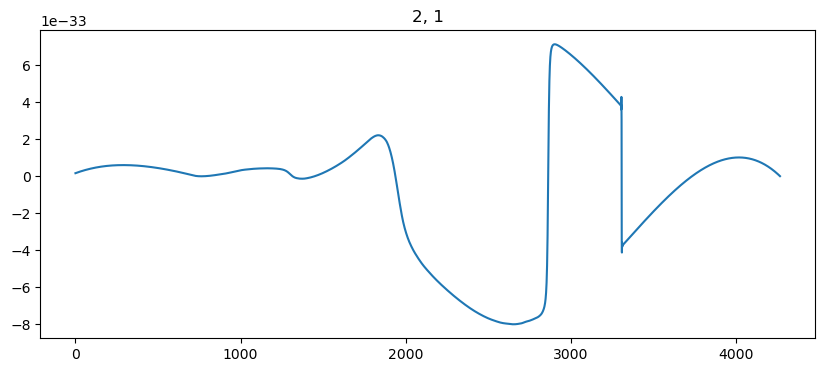

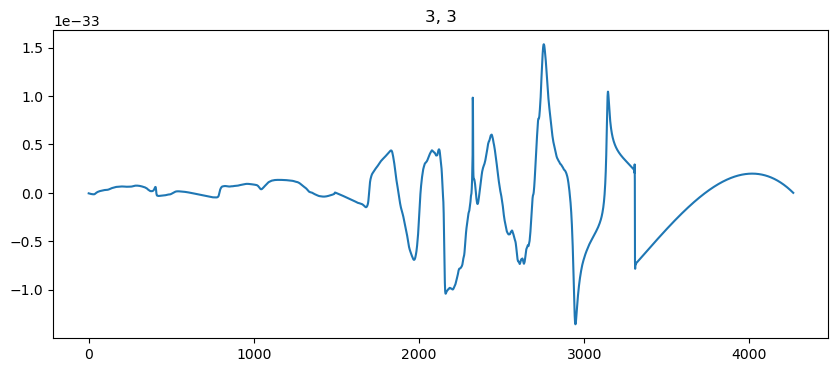

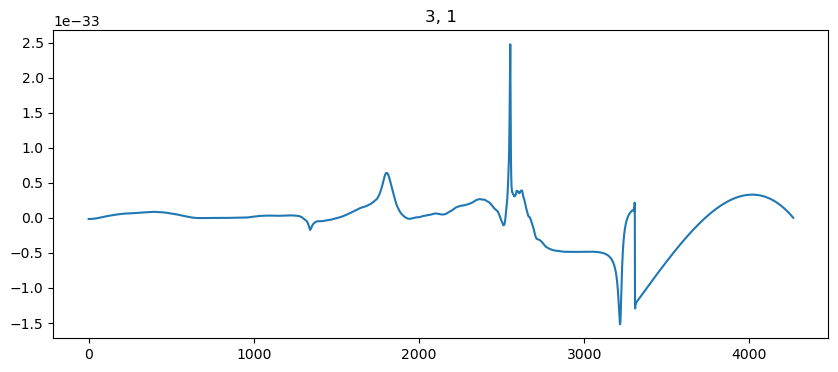

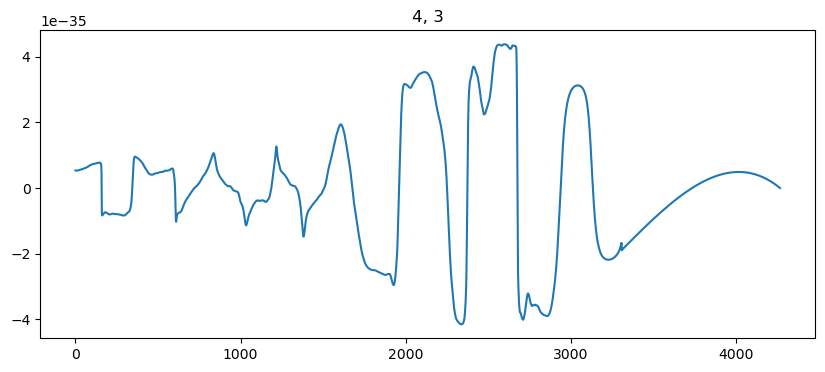

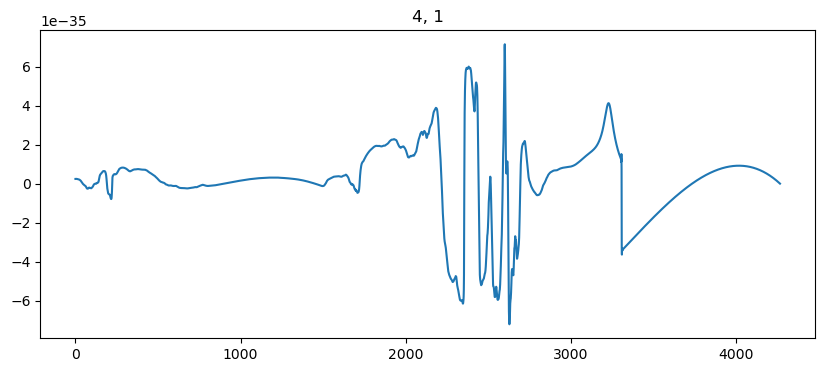

In [ ]:
for el, em in [
    (2, 1),
    (3, 3),
    (3, 1),
    (4, 3),
    (4, 1),
]:
    modes_rit = wfm_rit.get_mode(
        el,
        em,
        total_mass=total_mass,
        distance=distance,
        # coa_phase=np.pi / 2 - 0,
        delta_t=delta_t,
    )
    moderms = (
        np.abs(modes_rit.real().data) ** 2 + np.abs(modes_rit.imag().data) ** 2
    ).sum() ** 0.5
    print(el, em, moderms)

    sign1 = -1
    sign2 = -1

    plt.figure(figsize=(10, 4))
    plt.title(f"{el}, {em}")
    plt.plot(
        # modes_rit.real().sample_times,
        sign1 * modes_rit.real(),
        label=one_sim + "_real",
    )

False

dict_keys(['rPsi4_l3_m3_rInf', 'rPsi4_l4_m-3_rInf', 'rPsi4_l4_m4_rInf', 'rPsi4_l3_m-2_rInf', 'rPsi4_l3_m1_rInf', 'rPsi4_l4_m-1_rInf', 'rPsi4_l2_m2_rInf', 'rPsi4_l4_m1_rInf', 'rPsi4_l2_m1_rInf', 'rPsi4_l2_m0_rInf', 'rPsi4_l4_m2_rInf', 'rPsi4_l3_m-3_rInf', 'rPsi4_l4_m-4_rInf', 'rPsi4_l3_m0_rInf', 'rPsi4_l4_m3_rInf', 'rPsi4_l3_m2_rInf', 'rPsi4_l2_m-2_rInf', 'rPsi4_l2_m-1_rInf', 'rPsi4_l4_m0_rInf', 'rPsi4_l3_m-1_rInf', 'rPsi4_l4_m-2_rInf'])

In [166]:
psi422 = data["rPsi4_l2_m2_rInf"]

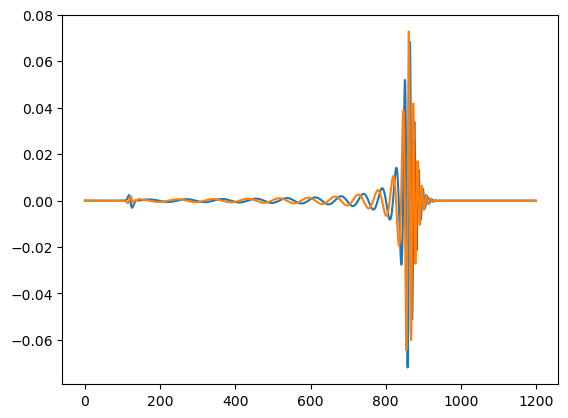

In [168]:
plt.plot(psi422[:, 0], psi422[:, 1])
plt.plot(psi422[:, 0], psi422[:, 2])

## Polarizations

In [ ]:
wfm_rit = ritcatalog.get(one_sim)

In [116]:
hp, hc = wf.get_td_waveform(
    approximant="NRSur7dq4", coa_phase=np.pi / 2 - 0, **one_sim_params
)
hp_rit = wfm_rit.get_td_waveform(
    total_mass=total_mass,
    distance=distance,
    inclination=inclination,
    coa_phase=np.pi / 2 - 0,
    delta_t=delta_t,
)
sign1 = 1
sign2 = -1

plt.figure(figsize=(12, 4))
plt.plot(hp.sample_times, hp, label="SEOB")
plt.plot(hp_rit.sample_times, sign1 * hp_rit.imag(), label=one_sim)
# plt.xlim(xmin=hp_rit.real().sample_times[0])
plt.legend()

plt.figure(figsize=(12, 4))
plt.plot(hc.sample_times, hc, label="SEOB")
plt.plot(hp_rit.sample_times, sign2 * hp_rit.real(), label=one_sim)
# plt.xlim(xmin=hp_rit.real().sample_times[0])
plt.legend()

XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1835): Error loading surrogate data.

XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1835): Generic failure
XLAL Error - XLALSimInspiralChooseTDWaveform (LALSimInspiral.c:1299): Internal function call failed: Generic failure


RuntimeError: Internal function call failed: Generic failure

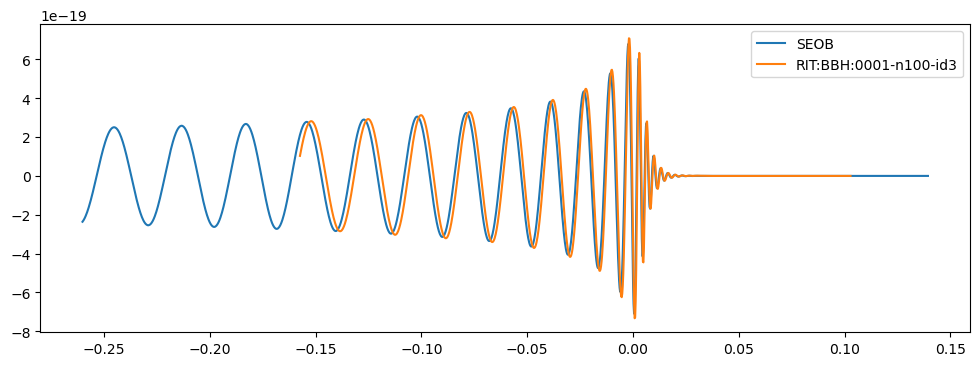

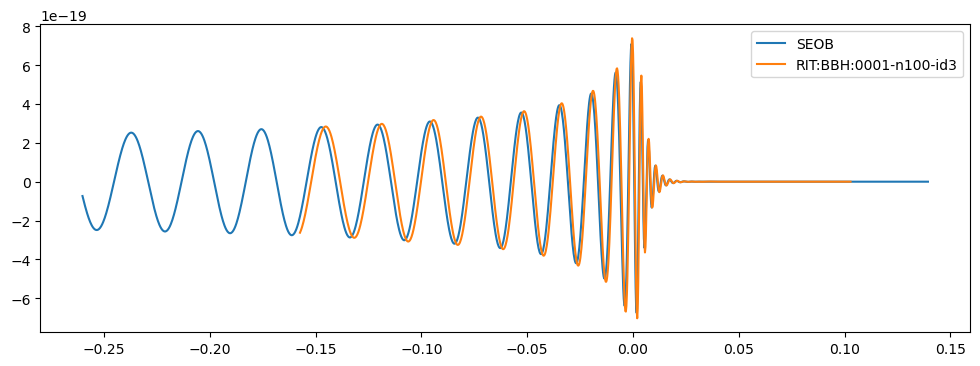

In [ ]:
hp, hc = wf.get_td_waveform(approximant="SEOBNRv4PHM", coa_phase=0, **one_sim_params)
hp_rit = wfm_rit.get_td_waveform(
    total_mass=total_mass,
    distance=distance,
    inclination=inclination,
    coa_phase=0,
    delta_t=delta_t,
)
sign1 = -1
sign2 = 1

plt.figure(figsize=(12, 4))
plt.plot(hp.sample_times, hp, label="SEOB")
plt.plot(hp_rit.sample_times, sign1 * hp_rit.imag(), label=one_sim)
# plt.xlim(xmin=hp_rit.real().sample_times[0])
plt.legend()

plt.figure(figsize=(12, 4))
plt.plot(hc.sample_times, hc, label="SEOB")
plt.plot(hp_rit.sample_times, sign2 * hp_rit.real(), label=one_sim)
# plt.xlim(xmin=hp_rit.real().sample_times[0])
plt.legend()

The above is showng an interesting pattern as to how $h_+$ and $h_\times$ are represented in `pycbc` waveforms versus how we do so. To recall

$$
h_+ -i h_\times = \sum_{l} \sum_{m} {}^{-2}Y_{lm}(\iota, \phi_c) h_{lm}
$$

Now lets denote our polarizations with superscript $h_+^o$, and those from `pycbc` with superscript $h_+^p$. We find from above that, for `coa_phase=0`:

$$
h_+^p = h_\times^o \\
h_\times^p = h_+^o \\
$$

ie.
$$
h^p = 
h_+^p -i h_\times^p = h_\times^o  -i h_+^o\\
= -i (h_+^o +i h_\times^o)\\
= -i (h^o)^*

$$

and for `coa_phase = $\pi/2$`:

$$
h_+^p = - h_\times^o \\
h_\times^p = - h_+^o \\

$$

#### Now let us look at NR surrogate waveforms

In [108]:
wf.waveform_modes._mode_waveform_td

{'NRSur7dq4': <function pycbc.waveform.waveform_modes.get_nrsur_modes(**params)>,
 'NRHybSur3dq8': <function pycbc.waveform.waveform_modes.get_nrhybsur_modes(**params)>}

In [99]:
hp, hc = wf.get_td_waveform_modes(
    approximant="NRSur7dq4", mass1=40, mass2=30, f_lower=20, delta_t=1.0 / 4096
)
# **one_sim_params)

XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1835): Error loading surrogate data.

XLAL Error - PrecessingNRSur_core (LALSimIMRPrecessingNRSur.c:1835): Generic failure


RuntimeError: Generic failure

/home/prayush/miniconda3/envs/enigma_spins_v2023/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


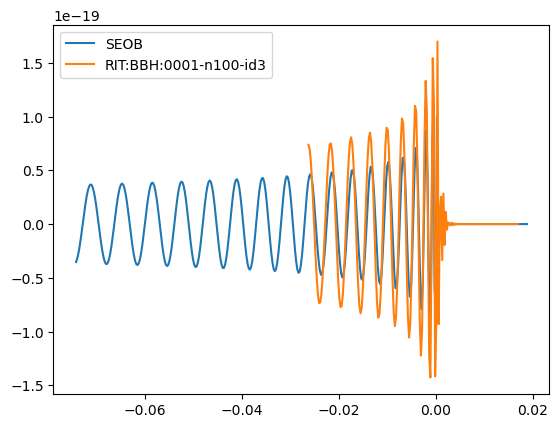

In [76]:
plt.plot(hp.sample_times, hp, label="SEOB")
plt.plot(m22_rit.sample_times, m22_rit, label=one_sim)
plt.legend()

In [ ]:
ampl = amplitude_from_polarizations

/home/prayush/miniconda3/envs/enigma_spins_v2023/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


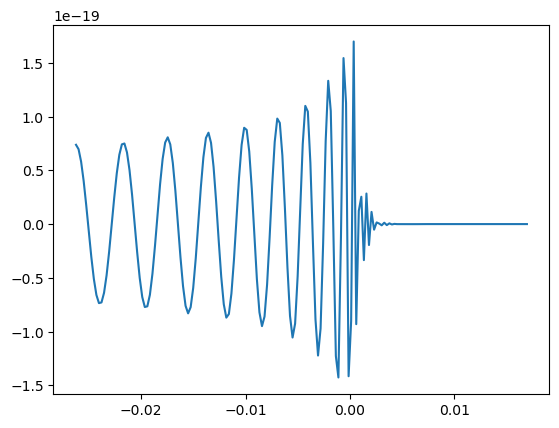

In [75]:
plt.plot(m22_rit.sample_times, m22_rit)